# Datenanalyse 

# Inhalt

* [Analyse Teildatensatz: Publikationen in Scopus und OpenAlex](#match)
* [Analyse Teildatensatz: Publikationen nur in Scopus](#only_scopus)
* [Analyse Teildatensatz: Publikationen nur in OpenAlex](#only_openalex)

## Import<a class="anchor" id="import"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from pysankey import sankey
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import matplotlib
from cycler import cycler

# Abfrage OpenAlex
from pyalex import Works, config
from itertools import chain
import os
from dotenv import load_dotenv

# polite pool, email will be read from .env file
load_dotenv()
config.email = os.getenv("user_email")

# configure setting for retry
config.max_retries = 1
config.retry_backoff_factor = 0.1
config.retry_http_codes = [429, 500, 503]

# Abfrage Scopus
import pybliometrics
from pybliometrics.scopus import ScopusSearch, AbstractRetrieval

pybliometrics.scopus.init()  # read API keys


# Daten für Publikation: für Scopus wird nur die id geseichert
# AUf False setzen, damit alle Daten aus Scopus gespeichert werden
publication = True 

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
%load_ext watermark
%watermark -v --iversions

Python implementation: CPython
Python version       : 3.11.2
IPython version      : 8.5.0

dotenv         : 0.9.9
pysankey       : 0.0.1
jupyter_black  : 0.4.0
matplotlib_venn: 1.1.2
cycler         : 0.11.0
matplotlib     : 3.6.3
pyalex         : 0.15.1
numpy          : 1.24.2
seaborn        : 0.13.2
pandas         : 1.5.3
pybliometrics  : 4.1



## Funktionen<a class="anchor" id="funktionen"></a>

In [4]:
SEABORN_PALETTES = dict(
    colorblind=[
        "#0173B2",
        "#DE8F05",
        "#029E73",
        "#D55E00",
        "#CC78BC",
        "#CA9161",
        "#FBAFE4",
        "#949494",
        "#ECE133",
        "#56B4E9",
    ],
)
# colors
matplotlib.rcParams["axes.prop_cycle"] = cycler(color=SEABORN_PALETTES["colorblind"])

In [5]:
# fix colors for plots - seaborn colorblind
colorDict_type = {  #
    "article": "#0173B2",
    "Article": "#0173B2",
    "review": "#DE8F05",
    "Review": "#DE8F05",
    "Conference Paper": "#029E73",
    "report": "#029E73",
    "letter": "#D55E00",
    "Letter": "#D55E00",
    "editorial": "#CC78BC",
    "Editorial": "#CC78BC",
    "Book Chapter": "#CA9161",
    "book-chapter": "#CA9161",
    "erratum": "#FBAFE4",
    "Erratum": "#FBAFE4",
    "note": "#949494",
    "Note": "#949494",
    "book": "#ECE133",
    "Book": "#ECE133",
    "Data Paper": "#56B4E9",
    "Retracted": "#0173B2",
    "other": "#0173B2",
    "Short Survey": "#56B4E9",
    "none": "#56B4E9",
}
colorDict_source = {
    "journal": "#0173B2",
    "Journal": "#0173B2",
    "conference proceeding": "#DE8F05",
    "Conference Proceeding": "#DE8F05",
    "book": "#029E73",
    "Book": "#029E73",
    "book series": "#D55E00",
    "Book Series": "#D55E00",
    "repository": "#CC78BC",
    "ebook platform": "#CA9161",
    "conference": "#FBAFE4",
    "other": "#949494",
    "other2": "#ECE133",
    "none": "#56B4E9",
}

colorDict_year = {
    2010: "#0173B2",
    2011: "#DE8F05",
    2012: "#029E73",
    2013: "#D55E00",
    2020: "#0173B2",
    2021: "#DE8F05",
    2022: "#029E73",
    2023: "#D55E00",
}

## Daten einlesen


In [8]:
# Einlesen aller Daten
# Für das weitere Skript wird angenommen, dass alle Scopus Metadaten vorhanden sind

# 2010 - 2013
data_2010_only_scopus = pd.read_csv("data/diff/data_2010_only_scopus.csv")
data_2010_only_openalex = pd.read_csv("data/diff/data_2010_only_openalex.csv")
data_2010_matched = pd.read_csv("data/diff/data_2010_matched.csv")

# 2020 - 2023
data_2020_only_scopus = pd.read_csv("data/diff/data_2020_only_scopus.csv")
data_2020_only_openalex = pd.read_csv("data/diff/data_2020_only_openalex.csv")
data_2020_matched = pd.read_csv("data/diff/data_2020_matched.csv")

In [9]:
data_2010_matched.columns

Index(['Unnamed: 0', 'scopus_id', 'doi', 'pii', 'pubmed_id', 'scopus_title',
       'subtype', 'subtypeDescription', 'creator', 'afid', 'affilname',
       'affiliation_city', 'affiliation_country', 'author_count',
       'author_names', 'author_ids', 'author_afids', 'coverDate',
       'coverDisplayDate', 'scopus_source_title', 'issn', 'source_id', 'eIssn',
       'aggregationType', 'scopus_volume', 'issueIdentifier', 'article_number',
       'pageRange', 'description', 'authkeywords', 'citedby_count',
       'openaccess', 'freetoread', 'freetoreadLabel', 'fund_acr', 'fund_no',
       'fund_sponsor', 'scopus_name_1st_author', 'scopus_publication_year',
       'openalex_id', 'openalex_title', 'type', 'publication_date',
       'openalex_publication_year', 'openalex_volume', 'issue', 'first_page',
       'last_page', 'authors', 'keywords', 'abstract', 'openalex_source_title',
       'source_issn', 'source_type', 'cited_by_count', 'referenced_works',
       'openalex_name_1st_author', 'm

## Analyse Teildatensatz: Publikationen in Scopus und OpenAlex<a class="anchor" id="match"></a>

Zu erst werden die gematchten Dokumente aus Scopus und OpenAlex betrachtet. 

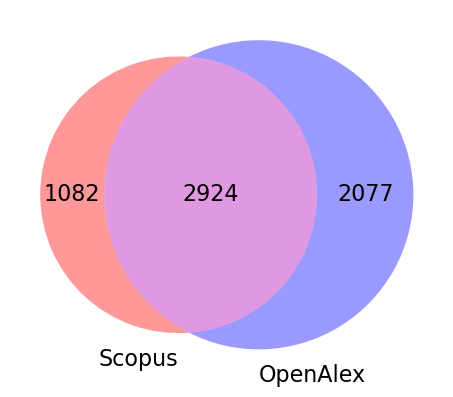

In [10]:
size_2010_only_scopus = data_2010_only_scopus.shape[0]
size_2010_only_openalex = data_2010_only_openalex.shape[0]
size_2010_matched = data_2010_matched.shape[0]

out = venn2(
    subsets=(size_2010_only_scopus, size_2010_only_openalex, size_2010_matched),
    set_labels=("Scopus", "OpenAlex"),
    set_colors=("red", "blue"),
)
for text in out.set_labels:
    text.set_fontsize(16)  # labels below
for text in out.subset_labels:
    text.set_fontsize(16)  # numbers
plt.savefig("figures/venn_2010.png", bbox_inches="tight", dpi=300)

In [141]:
print(
    f"Von {size_2010_only_scopus + size_2010_matched} Suchergebnissen in Scopus konnten {size_2010_matched} ({size_2010_matched/(size_2010_only_scopus + size_2010_matched)*100:.2f} %) gematcht werden."
)

Von 4006 Suchergebnissen in Scopus konnten 2924 (72.99 %) gematcht werden.


In [142]:
# Daten ohne DOI für 2010 - 2013

data_2010_matched[data_2010_matched["doi"].isnull()].shape[0]

42

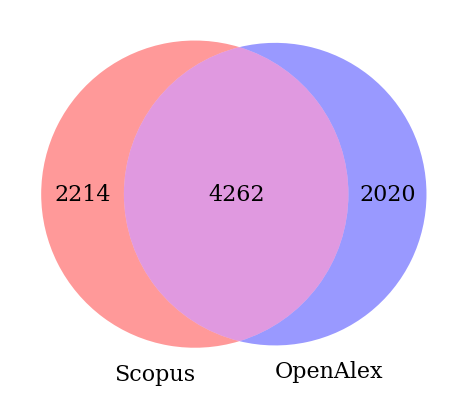

In [143]:
size_2020_only_scopus = data_2020_only_scopus.shape[0]
size_2020_only_openalex = data_2020_only_openalex.shape[0]
size_2020_matched = data_2020_matched.shape[0]

out = venn2(
    subsets=(size_2020_only_scopus, size_2020_only_openalex, size_2020_matched),
    set_labels=("Scopus", "OpenAlex"),
    set_colors=("red", "blue"),
)
for text in out.set_labels:
    text.set_fontsize(16)  # labels below
for text in out.subset_labels:
    text.set_fontsize(16)  # numbers
plt.savefig("figures/venn_2020.png", bbox_inches="tight", dpi=300)

In [144]:
print(
    f"Von {size_2020_only_scopus + size_2020_matched} Suchergebnissen in Scopus konnten {size_2020_matched} ({size_2020_matched/(size_2020_only_scopus + size_2020_matched)*100:.2f} %) gematcht werden."
)

Von 6476 Suchergebnissen in Scopus konnten 4262 (65.81 %) gematcht werden.


In [145]:
# Daten ohne DOI für 2020 - 2023
data_2020_matched[data_2020_matched["doi"].isnull()].shape[0]

24

### Analyse der gematchten Daten - Metadaten

In [146]:
# Publikationstypen

### Dokumententypen

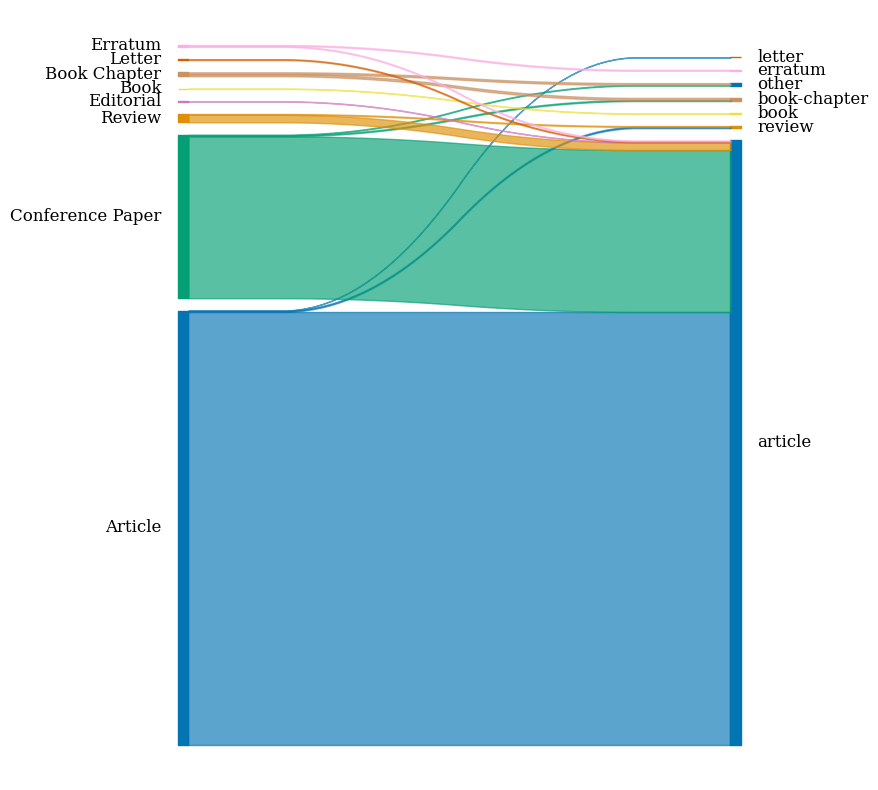

In [148]:
plt.gcf().set_size_inches(8, 10)
sankey(
    data_2010_matched["subtypeDescription"],
    data_2010_matched["type"],
    aspect=20,  # no effect
    fontsize=12,
    colorDict=colorDict_type,
)
plt.savefig("figures/sankey_2010_matched_doctype.png", bbox_inches="tight", dpi=300)

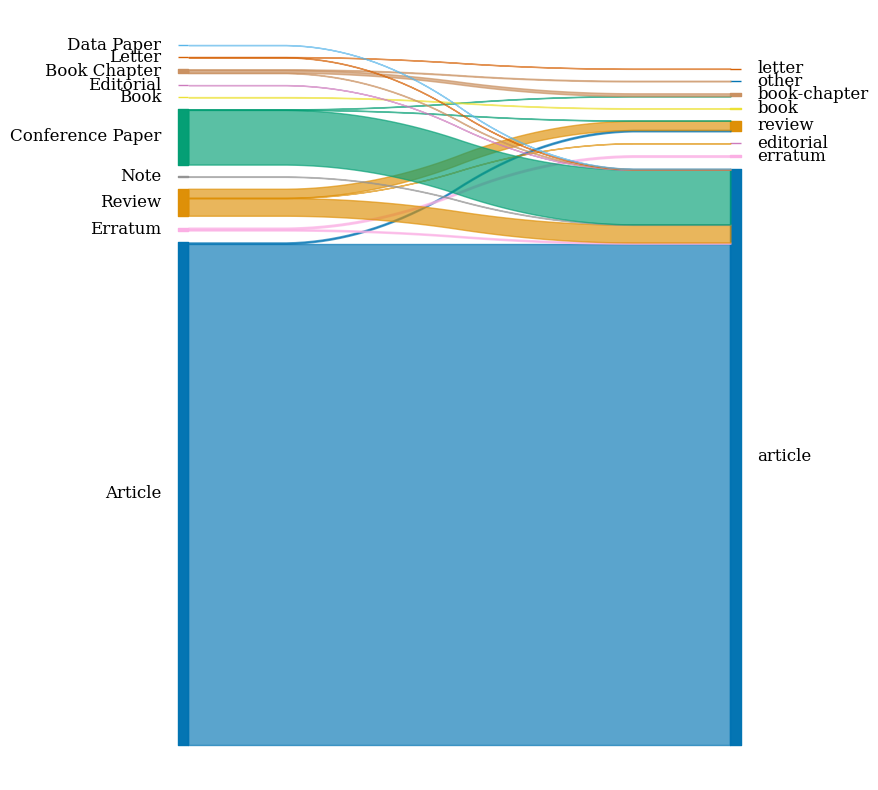

In [149]:
plt.gcf().set_size_inches(8, 10)
sankey(
    data_2020_matched["subtypeDescription"],
    data_2020_matched["type"],
    aspect=20,
    fontsize=12,
    colorDict=colorDict_type,
)
plt.savefig("figures/sankey_2020_matched_doctype.png", bbox_inches="tight", dpi=300)

In [ ]:
data_2020_matched[data_2020_matched["type"] == "editorial"]

### Quelltypen

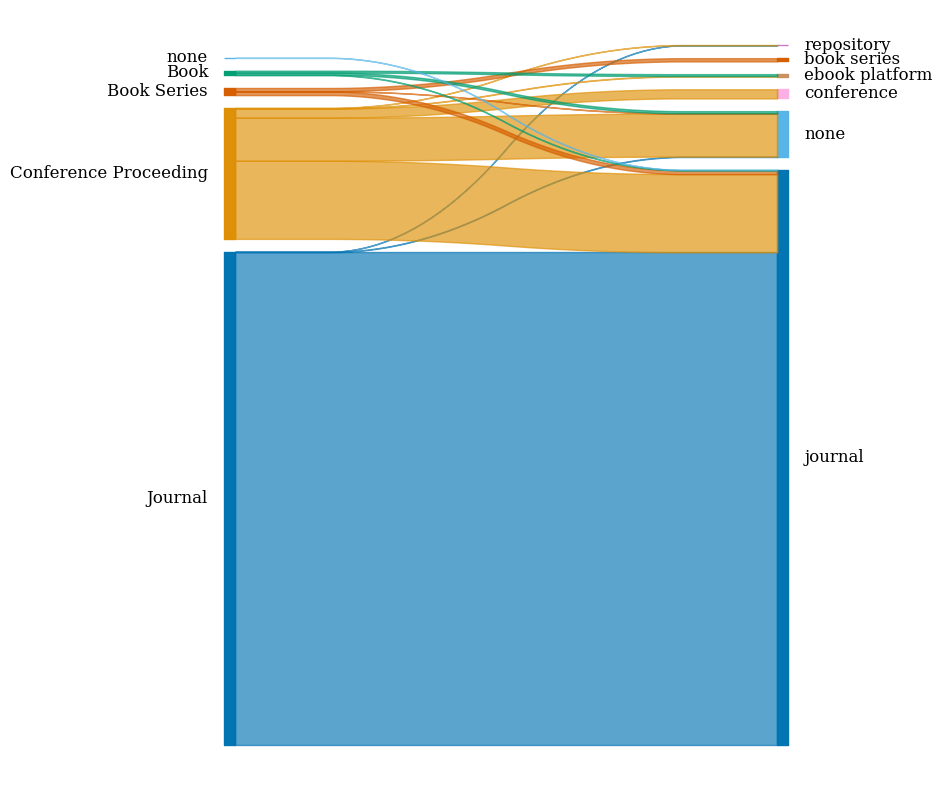

In [151]:
# change missing values to string
data_2010_matched["source_type"].fillna(value="none", inplace=True)
data_2010_matched["aggregationType"].fillna(value="none", inplace=True)

plt.gcf().set_size_inches(8, 10)
sankey(
    data_2010_matched["aggregationType"],
    data_2010_matched["source_type"],
    aspect=20,
    fontsize=12,
    colorDict=colorDict_source,
)
plt.savefig(
    "figures/sankey_2010_matched_aggregation_type.png", bbox_inches="tight", dpi=300
)

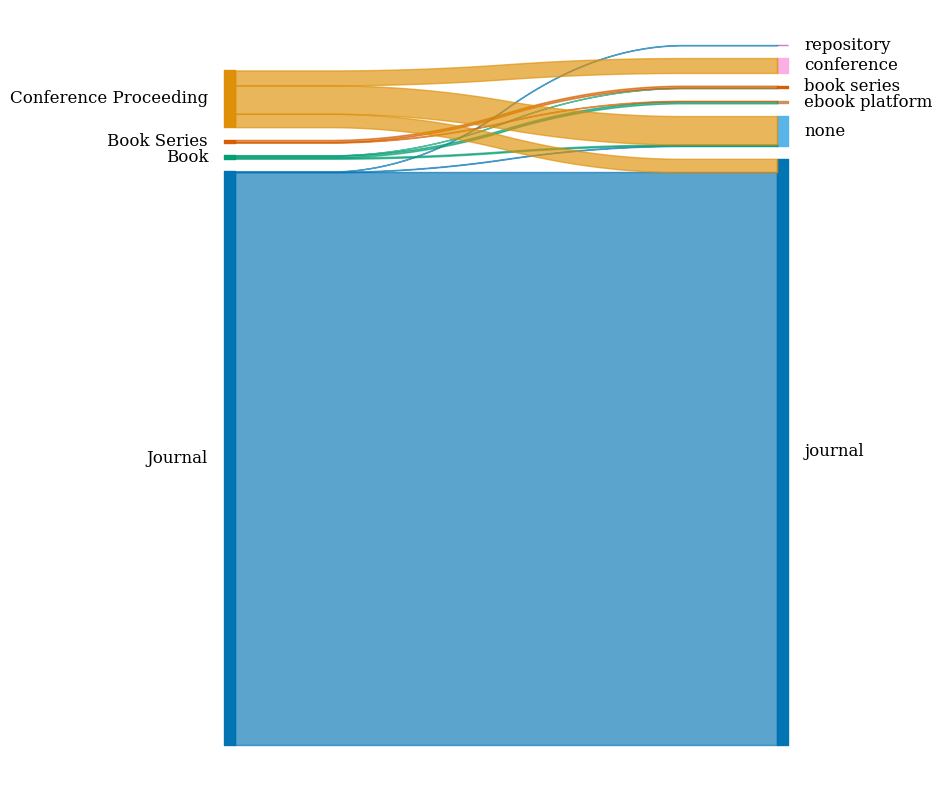

In [152]:
# change missing values to string
data_2020_matched["source_type"].fillna(value="none", inplace=True)
data_2020_matched["aggregationType"].fillna(value="none", inplace=True)

plt.gcf().set_size_inches(8, 10)
sankey(
    data_2020_matched["aggregationType"],
    data_2020_matched["source_type"],
    aspect=20,
    fontsize=12,
    colorDict=colorDict_source,
)
plt.savefig(
    "figures/sankey_2020_matched_aggregation_type.png", bbox_inches="tight", dpi=300
)

### Publikationsjahr

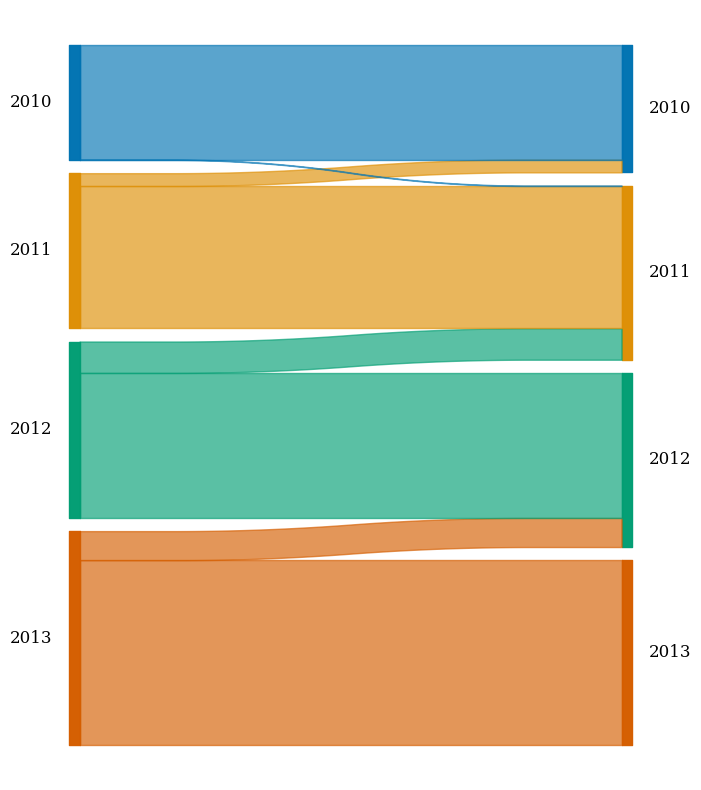

In [153]:
plt.gcf().set_size_inches(8, 10)
sankey(
    data_2010_matched["scopus_publication_year"],
    data_2010_matched["openalex_publication_year"],
    aspect=20,
    fontsize=12,
    colorDict=colorDict_year,
)
plt.savefig(
    "figures/sankey_2010_matched_publication_year.png", bbox_inches="tight", dpi=300
)

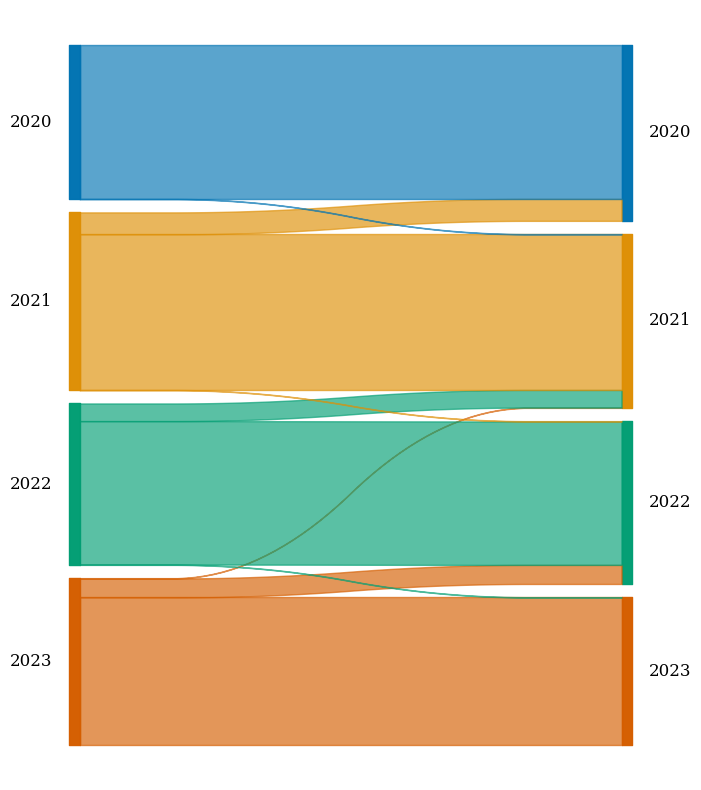

In [154]:
plt.gcf().set_size_inches(8, 10)
sankey(
    data_2020_matched["scopus_publication_year"],
    data_2020_matched["openalex_publication_year"],
    aspect=20,
    fontsize=12,
    colorDict=colorDict_year,
)
plt.savefig(
    "figures/sankey_2020_matched_publication_year.png", bbox_inches="tight", dpi=300
)

In [155]:
# Wann Publikationsjahr in Scopus > Publikationsjahr in OpenAlex?
data_2020_matched[
    data_2020_matched["scopus_publication_year"]
    > data_2020_matched["openalex_publication_year"]
].shape[0]

381

In [ ]:
# Wann Publikationsjahr in Scopus < Publikationsjahr in OpenAlex?
data = data_2020_matched[
    data_2020_matched["scopus_publication_year"]
    < data_2020_matched["openalex_publication_year"]
]
data[
    [
        "doi",
        "scopus_title",
        "openalex_title",
        "scopus_name_1st_author",
        "scopus_name_1st_author",
        "scopus_publication_year",
        "openalex_publication_year",
    ]
]

In [ ]:
data_2010_matched["citedby_count"]

In [ ]:
data_2010_matched["cited_by_count"]

In [163]:
data_2010_matched["referenced_works"]

0       ['https://openalex.org/W1916102167', 'https://...
1       ['https://openalex.org/W1569059103', 'https://...
2       ['https://openalex.org/W1982677590', 'https://...
3       ['https://openalex.org/W1563938275', 'https://...
4       ['https://openalex.org/W1576018780', 'https://...
                              ...                        
2919                  ['https://openalex.org/W137363777']
2920    ['https://openalex.org/W1977191928', 'https://...
2921    ['https://openalex.org/W1968089027', 'https://...
2922    ['https://openalex.org/W1337966', 'https://ope...
2923                                                   []
Name: referenced_works, Length: 2924, dtype: object

### Analyse der Anzahl der Zitationen und Referenzen

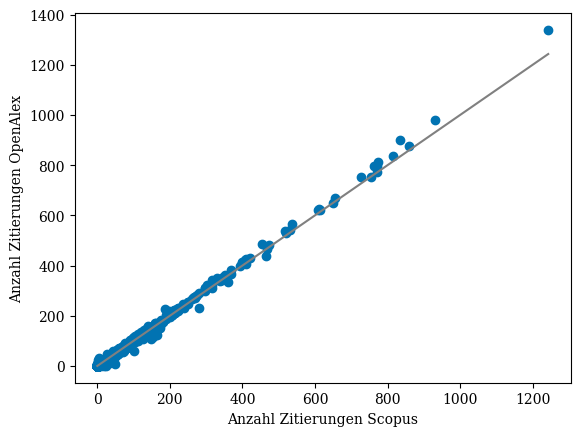

In [164]:
# citation 2010
x = np.linspace(0, int(data_2010_matched["citedby_count"].max()))
plt.plot(data_2010_matched["citedby_count"], data_2010_matched["cited_by_count"], "o")
plt.ylabel("Anzahl Zitierungen OpenAlex")
plt.xlabel("Anzahl Zitierungen Scopus")
plt.plot(x, x, color="grey")
plt.savefig("figures/plot_2010_citation_count.png")

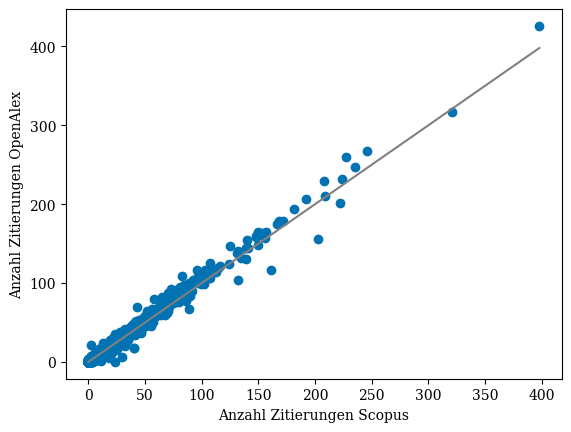

In [165]:
# citation 2020
x = np.linspace(0, int(data_2020_matched["citedby_count"].max()))
plt.plot(data_2020_matched["citedby_count"], data_2020_matched["cited_by_count"], "o")
plt.ylabel("Anzahl Zitierungen OpenAlex")
plt.xlabel("Anzahl Zitierungen Scopus")
plt.plot(x, x, color="grey")
plt.savefig("figures/plot_2020_citation_count.png")

In [166]:
# Einträge ohne Referenzen 2010
data_2010_matched[data_2010_matched["referenced_works"] == "[]"].shape[0]

390

In [167]:
# Einträge ohne Referenzen 2020
data_2020_matched[data_2020_matched["referenced_works"] == "[]"].shape[0]

112

## Analyse der Unterschiede - Daten nur in Scopus<a class="anchor" id="only_scopus"></a>

In [168]:
data_2010_only_scopus.shape[0]

1082

In [169]:
data_2020_only_scopus.shape[0]

2214

In [170]:
# Daten ohne DOI für 2010 - 2013
data_2010_only_scopus[data_2010_only_scopus["doi"].isnull()].shape[0]

127

In [171]:
# Daten ohne DOI für 2020 - 2023
data_2020_only_scopus[data_2020_only_scopus["doi"].isnull()].shape[0]

64

In [172]:
data_2010_only_scopus.groupby(["scopus_publication_year", "subtypeDescription"]).size()

scopus_publication_year  subtypeDescription
2010                     Article               137
                         Book Chapter           10
                         Conference Paper       94
                         Letter                  1
                         Review                  1
2011                     Article               123
                         Book Chapter            5
                         Conference Paper      107
                         Erratum                 1
                         Review                  4
2012                     Article               148
                         Book Chapter           11
                         Conference Paper       92
                         Letter                  2
                         Review                  4
2013                     Article               209
                         Book Chapter            6
                         Conference Paper      118
                         Letter       

Welche Dokumententypen liegen vor?

In [173]:
data_2010_only_scopus["subtypeDescription"].value_counts()

Article             617
Conference Paper    411
Book Chapter         32
Review               17
Letter                4
Erratum               1
Name: subtypeDescription, dtype: int64

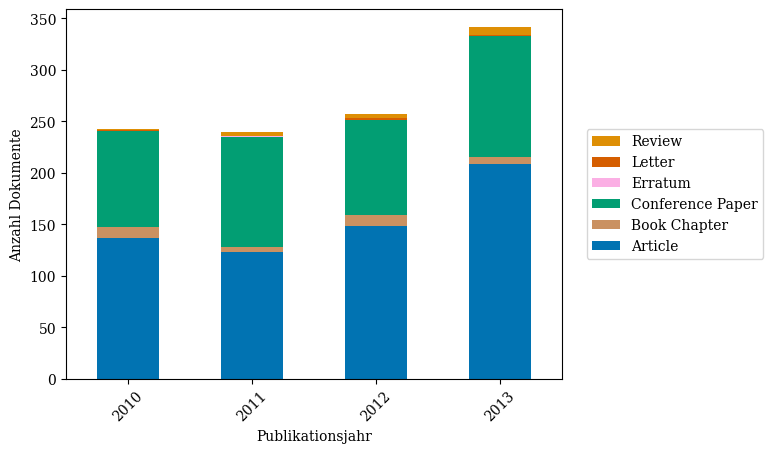

In [174]:
data_2010_only_scopus.groupby(
    ["scopus_publication_year", "subtypeDescription"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_type)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig("figures/plot_2010_scopus_doc_type_year.png", bbox_inches="tight", dpi=300)

In [175]:
data_2020_only_scopus["subtypeDescription"].value_counts()

Article             1855
Conference Paper     189
Review                95
Book Chapter          57
Book                   4
Erratum                4
Short Survey           3
Editorial              3
Note                   2
Retracted              1
Letter                 1
Name: subtypeDescription, dtype: int64

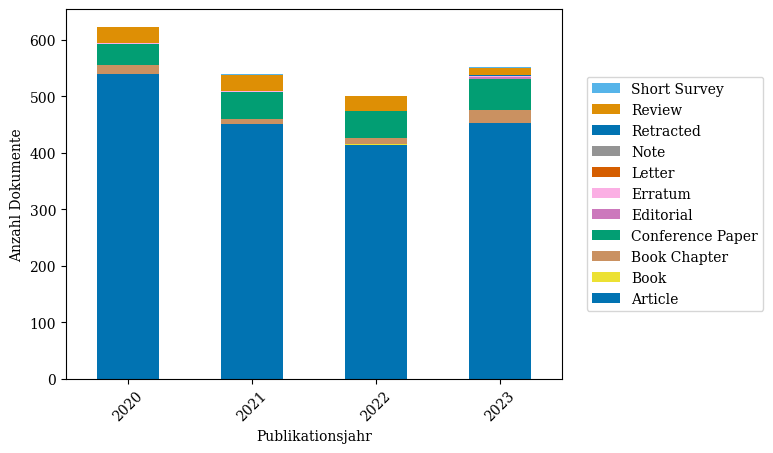

In [176]:
data_2020_only_scopus.groupby(
    ["scopus_publication_year", "subtypeDescription"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_type)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig("figures/plot_2020_scopus_doc_type_year.png", bbox_inches="tight", dpi=300)

Aus welchen Quelltypen stammen die Dokumente?

In [177]:
data_2010_only_scopus["aggregationType"].value_counts()

Journal                  737
Conference Proceeding    296
Book                      28
Book Series               21
Name: aggregationType, dtype: int64

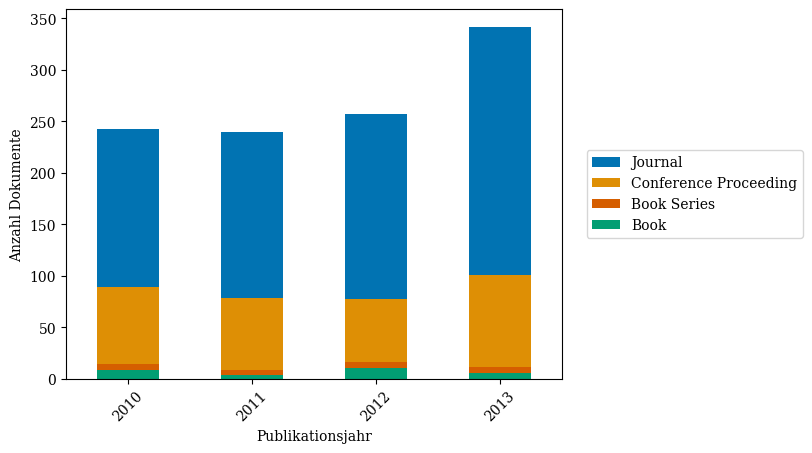

In [178]:
data_2010_only_scopus.groupby(
    ["scopus_publication_year", "aggregationType"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_source)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2010_scopus_source_type_year.png", bbox_inches="tight", dpi=300
)

In [179]:
data_2020_only_scopus["aggregationType"].value_counts()

Journal                  1970
Conference Proceeding     177
Book                       48
Book Series                19
Name: aggregationType, dtype: int64

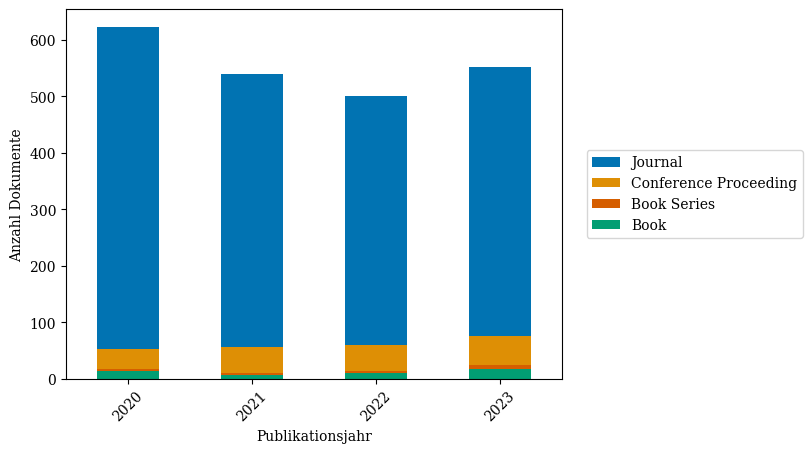

In [180]:
data_2020_only_scopus.groupby(
    ["scopus_publication_year", "aggregationType"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_source)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2020_scopus_source_type_year.png", bbox_inches="tight", dpi=300
)

Aus welchen Journalen sind die Dokumente? Gibt es evtl. Publisher die hier hervorstechen?

In [181]:
data_2010_only_scopus_journal = data_2010_only_scopus[
    data_2010_only_scopus["aggregationType"] == "Journal"
]
data_2010_only_scopus_journal.shape[0]

737

In [182]:
data_2020_only_scopus_journal = data_2020_only_scopus[
    data_2020_only_scopus["aggregationType"] == "Journal"
]
data_2020_only_scopus_journal.shape[0]

1970

In [ ]:
data_2010_only_scopus_journal["scopus_source_title"].value_counts().head(10)

In [ ]:
data_2020_only_scopus_journal["scopus_source_title"].value_counts().head(10)

Bei Publikationen  die nur in Scopus vorhanden sind gibt es verschiedene mögliche Ursache:   
a) die Verknüpfung zu einem Dokument in OpenAlex wurde wärend des Matchings nicht erstellt (z.B. da keine DOI und unvollständige Metadaten) oder  
b) die Daten sind in OpenAlex vorhanden waren aber nicht Teil der initialen Datenbankabfrage oder  
c) die Daten wurden in OpenAlex abgefragt, aber im Rahmen der Bereinigung entfernt.  

Um dies zu testen, wird anhand der DOI geprüft ob Publikationen nicht doch in OpenAlex vorhanden ist.


In [185]:
dois_nur_scopus_2010 = data_2010_only_scopus["doi"].dropna()
dois_nur_scopus_2020 = data_2020_only_scopus["doi"].dropna()

In [186]:
print(
    f"Für den Zeitraum 2010 - 2013 wurden {data_2010_only_scopus.shape[0]} Dokumente in Scopus gefunden. Hiervon besitzen {dois_nur_scopus_2010.shape[0]} eine DOI."
)
print(
    f"Für den Zeitraum 2020 - 2023 wurden {data_2020_only_scopus.shape[0]} Dokumente in Scopus gefunden. Hiervon besitzen {dois_nur_scopus_2020.shape[0]} eine DOI."
)

Für den Zeitraum 2010 - 2013 wurden 1082 Dokumente in Scopus gefunden. Hiervon besitzen 955 eine DOI.
Für den Zeitraum 2020 - 2023 wurden 2214 Dokumente in Scopus gefunden. Hiervon besitzen 2150 eine DOI.


In [187]:
dois_nur_scopus_2010

0                  10.1039/c3ra45966g
1                   10.1021/am4043195
2           10.1109/isam.2013.6643520
3      10.1016/j.surfcoat.2013.06.082
4                   10.1063/1.4857135
                    ...              
950                 10.1149/1.3248002
951                 10.1149/1.3246802
952    10.1016/j.jcrysgro.2009.10.028
953     10.1088/0957-4484/21/1/015302
954         10.1016/j.cap.2009.04.011
Name: doi, Length: 955, dtype: object

In [188]:
# volle URL für OpenAlex
dois_nur_scopus_2010 = "https://doi.org/" + dois_nur_scopus_2010
dois_nur_scopus_2020 = "https://doi.org/" + dois_nur_scopus_2020

dois_nur_scopus_2010

0                  https://doi.org/10.1039/c3ra45966g
1                   https://doi.org/10.1021/am4043195
2           https://doi.org/10.1109/isam.2013.6643520
3      https://doi.org/10.1016/j.surfcoat.2013.06.082
4                   https://doi.org/10.1063/1.4857135
                            ...                      
950                 https://doi.org/10.1149/1.3248002
951                 https://doi.org/10.1149/1.3246802
952    https://doi.org/10.1016/j.jcrysgro.2009.10.028
953     https://doi.org/10.1088/0957-4484/21/1/015302
954         https://doi.org/10.1016/j.cap.2009.04.011
Name: doi, Length: 955, dtype: object

In [189]:
def get_openalex_works_from_doi(doi_list):
    all_works_openalex = []
    dois_not_found = []

    for doi in doi_list:
        try:
            # save data if entry found
            work = Works()[doi]
            all_works_openalex.append(work)
        except:
            # HTTP error if doi not in OpenAlex
            dois_not_found.append(doi)

    # dataframe from dictiony
    all_works_openalex_df = pd.DataFrame.from_dict(all_works_openalex)

    return (all_works_openalex_df, dois_not_found)

In [190]:
# check for 2010 (7 Min.)
data_2010_openalex_not_in_scopus, not_found_2010 = get_openalex_works_from_doi(
    dois_nur_scopus_2010
)

In [191]:
print(
    f"Von den {dois_nur_scopus_2010.shape[0]} nur in Scopus gefundenen Dokumenten mit DOI, konnten in openAlex {data_2010_openalex_not_in_scopus.shape[0]} Dokumente mittels einer Suche nach der DOI gefunden werden."
)

Von den 955 nur in Scopus gefundenen Dokumenten mit DOI, konnten in openAlex 946 Dokumente mittels einer Suche nach der DOI gefunden werden.


In [192]:
data_2010_openalex_not_in_scopus

,id,doi,title,display_name,publication_year,publication_date,ids,language,primary_location,type,...,versions,referenced_works_count,referenced_works,related_works,abstract_inverted_index,abstract_inverted_index_v3,cited_by_api_url,counts_by_year,updated_date,created_date
0,https://openalex.org/W1983244187,https://doi.org/10.1039/c3ra45966g,Silicon protected with atomic layer deposited ...,Silicon protected with atomic layer deposited ...,2013,2013-01-01,{'openalex': 'https://openalex.org/W1983244187...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],18,"[https://openalex.org/W1967235816, https://ope...","[https://openalex.org/W4311100803, https://ope...","{'The': [0], 'semiconducting': [1], 'materials...",None,https://api.openalex.org/works?filter=cites:W1...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",2025-06-05T18:50:08.174847,2016-06-24
1,https://openalex.org/W2330832516,https://doi.org/10.1021/am4043195,Area Selective Molecular Layer Deposition of P...,Area Selective Molecular Layer Deposition of P...,2013,2013-11-14,{'openalex': 'https://openalex.org/W2330832516...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],22,"[https://openalex.org/W1969023135, https://ope...","[https://openalex.org/W4386760791, https://ope...","{'Patterned': [0], 'organic': [1, 27, 47, 244]...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 1}, {'year':...",2025-06-17T06:52:44.004776,2016-06-24
2,https://openalex.org/W2047571859,https://doi.org/10.1109/isam.2013.6643520,Fault diagnosis based on nonlinear dynamic mod...,Fault diagnosis based on nonlinear dynamic mod...,2013,2013-07-01,{'openalex': 'https://openalex.org/W2047571859...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],15,"[https://openalex.org/W1967271445, https://ope...","[https://openalex.org/W4281808365, https://ope...","{'In': [0], 'order': [1], 'to': [2, 62], 'diag...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",2025-06-20T13:41:18.907426,2016-06-24
3,https://openalex.org/W2063687540,https://doi.org/10.1016/j.surfcoat.2013.06.082,Lubricious zinc titanate coatings for high tem...,Lubricious zinc titanate coatings for high tem...,2013,2013-06-26,{'openalex': 'https://openalex.org/W2063687540...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],35,"[https://openalex.org/W132586983, https://open...","[https://openalex.org/W657245677, https://open...",None,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 2}, {'year':...",2025-06-15T19:22:48.458454,2016-06-24
4,https://openalex.org/W2044515112,https://doi.org/10.1063/1.4857135,Schottky barrier height reduction for metal/n-...,Schottky barrier height reduction for metal/n-...,2013,2013-12-23,{'openalex': 'https://openalex.org/W2044515112...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],30,"[https://openalex.org/W1480606358, https://ope...","[https://openalex.org/W2917180890, https://ope...","{'Fermi': [0], 'level': [1], 'pinning': [2], '...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 1}, {'year':...",2025-05-24T15:57:38.187419,2016-06-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,https://openalex.org/W2065807486,https://doi.org/10.1149/1.3248002,High Quality Area-Selective Atomic Layer Depos...,High Quality Area-Selective Atomic Layer Depos...,2009,2009-12-04,{'openalex': 'https://openalex.org/W2065807486...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],43,"[https://openalex.org/W1970541974, https://ope...","[https://openalex.org/W2333114585, https://ope...","{'Atomic': [0], 'layer': [1], 'deposition': [2...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",2025-06-09T09:04:49.710001,2016-06-24
942,https

In [193]:
# check for 2020 (19 Min.)
data_2020_openalex_not_in_scopus, not_found_2020 = get_openalex_works_from_doi(
    dois_nur_scopus_2020
)

In [194]:
print(
    f"Von den {dois_nur_scopus_2020.shape[0]} nur in Scopus gefundenen Dokumenten mit DOI, konnten in openAlex {data_2020_openalex_not_in_scopus.shape[0]} Dokumente mittels einer Suche nach der DOI gefunden werden."
)

Von den 2150 nur in Scopus gefundenen Dokumenten mit DOI, konnten in openAlex 2085 Dokumente mittels einer Suche nach der DOI gefunden werden.


In [195]:
data_2010_openalex_not_in_scopus

,id,doi,title,display_name,publication_year,publication_date,ids,language,primary_location,type,...,versions,referenced_works_count,referenced_works,related_works,abstract_inverted_index,abstract_inverted_index_v3,cited_by_api_url,counts_by_year,updated_date,created_date
0,https://openalex.org/W1983244187,https://doi.org/10.1039/c3ra45966g,Silicon protected with atomic layer deposited ...,Silicon protected with atomic layer deposited ...,2013,2013-01-01,{'openalex': 'https://openalex.org/W1983244187...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],18,"[https://openalex.org/W1967235816, https://ope...","[https://openalex.org/W4311100803, https://ope...","{'The': [0], 'semiconducting': [1], 'materials...",None,https://api.openalex.org/works?filter=cites:W1...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",2025-06-05T18:50:08.174847,2016-06-24
1,https://openalex.org/W2330832516,https://doi.org/10.1021/am4043195,Area Selective Molecular Layer Deposition of P...,Area Selective Molecular Layer Deposition of P...,2013,2013-11-14,{'openalex': 'https://openalex.org/W2330832516...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],22,"[https://openalex.org/W1969023135, https://ope...","[https://openalex.org/W4386760791, https://ope...","{'Patterned': [0], 'organic': [1, 27, 47, 244]...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 1}, {'year':...",2025-06-17T06:52:44.004776,2016-06-24
2,https://openalex.org/W2047571859,https://doi.org/10.1109/isam.2013.6643520,Fault diagnosis based on nonlinear dynamic mod...,Fault diagnosis based on nonlinear dynamic mod...,2013,2013-07-01,{'openalex': 'https://openalex.org/W2047571859...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],15,"[https://openalex.org/W1967271445, https://ope...","[https://openalex.org/W4281808365, https://ope...","{'In': [0], 'order': [1], 'to': [2, 62], 'diag...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",2025-06-20T13:41:18.907426,2016-06-24
3,https://openalex.org/W2063687540,https://doi.org/10.1016/j.surfcoat.2013.06.082,Lubricious zinc titanate coatings for high tem...,Lubricious zinc titanate coatings for high tem...,2013,2013-06-26,{'openalex': 'https://openalex.org/W2063687540...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],35,"[https://openalex.org/W132586983, https://open...","[https://openalex.org/W657245677, https://open...",None,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 2}, {'year':...",2025-06-15T19:22:48.458454,2016-06-24
4,https://openalex.org/W2044515112,https://doi.org/10.1063/1.4857135,Schottky barrier height reduction for metal/n-...,Schottky barrier height reduction for metal/n-...,2013,2013-12-23,{'openalex': 'https://openalex.org/W2044515112...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],30,"[https://openalex.org/W1480606358, https://ope...","[https://openalex.org/W2917180890, https://ope...","{'Fermi': [0], 'level': [1], 'pinning': [2], '...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 1}, {'year':...",2025-05-24T15:57:38.187419,2016-06-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,https://openalex.org/W2065807486,https://doi.org/10.1149/1.3248002,High Quality Area-Selective Atomic Layer Depos...,High Quality Area-Selective Atomic Layer Depos...,2009,2009-12-04,{'openalex': 'https://openalex.org/W2065807486...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],43,"[https://openalex.org/W1970541974, https://ope...","[https://openalex.org/W2333114585, https://ope...","{'Atomic': [0], 'layer': [1], 'deposition': [2...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",2025-06-09T09:04:49.710001,2016-06-24
942,https

In [196]:
not_found_2010
# Doi-Beginn 10.3969/j.issn -> chinesisches Journal "Chinese Journal of Vacuum Science and Technology" (ISSN 1672-7126)
# https://doi.org/10.1021/nl401833p -> Nano Letters, Quelle in OpenAle

['https://doi.org/10.3969/j.issn.1003-9015.2013.06.015',
 'https://doi.org/10.1021/nl401833p',
 'https://doi.org/10.3969/j.issn.1672-7126.2012.09.15',
 'https://doi.org/10.3969/j.issn.1003-6520.2012.07.029',
 'https://doi.org/10.3969/j.issn.1001-2400.2012.02.027',
 'https://doi.org/10.3850/978-981-08-7615-9-bs03',
 'https://doi.org/10.3969/j.issn.1672-7126.2011.01.11',
 'https://doi.org/10.3969/j.issn.1672-7126.2010.03.16',
 'https://doi.org/10.1149/1.3193683']

In [ ]:
data_2010_only_scopus[data_2010_only_scopus["doi"] == "10.1149/1.3193683"]

In [198]:
print(
    f"Von {data_2010_only_scopus.shape[0]} nicht gematchten Publikationen haben {dois_nur_scopus_2010.shape[0]} eine DOI. Hiervon konnte für {data_2010_openalex_not_in_scopus.shape[0]} ein Eintrag in OpenAlex gefunden werden. \nNur {len(not_found_2010)} DOIs konnten nicht in OpenAlex gefunden werden."
)

# Welchen Jahren sind diese Daten zugeordnet?
data_2010_openalex_not_in_scopus["publication_year"].value_counts().sort_index()

Von 1082 nicht gematchten Publikationen haben 955 eine DOI. Hiervon konnte für 946 ein Eintrag in OpenAlex gefunden werden. 
Nur 9 DOIs konnten nicht in OpenAlex gefunden werden.


1970      1
2009     88
2010    159
2011    205
2012    239
2013    251
2014      2
2016      1
Name: publication_year, dtype: int64

In [199]:
data_2010_openalex_not_in_scopus[
    data_2010_openalex_not_in_scopus["publication_year"] == 2016
]
# in Scopus and WoS: published in 2011, DOI does not resolve, can't check

,id,doi,title,display_name,publication_year,publication_date,ids,language,primary_location,type,...,versions,referenced_works_count,referenced_works,related_works,abstract_inverted_index,abstract_inverted_index_v3,cited_by_api_url,counts_by_year,updated_date,created_date
633,https://openalex.org/W4239153400,https://doi.org/10.3365/kjmm.2011.49.6.498,Properties of ZnO/TiO2 Bilayer Thin Films with...,Properties of ZnO/TiO2 Bilayer Thin Films with...,2016,2016-06-05,{'openalex': 'https://openalex.org/W4239153400...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],0,[],"[https://openalex.org/W4200206782, https://ope...",None,None,https://api.openalex.org/works?filter=cites:W4...,[],2025-01-24T07:51:58.326635,2022-05-12


In [200]:
data_2010_openalex_not_in_scopus[
    data_2010_openalex_not_in_scopus["publication_year"] == 1970
]
#  wrong publication year in openalex, correct: 2011

,id,doi,title,display_name,publication_year,publication_date,ids,language,primary_location,type,...,versions,referenced_works_count,referenced_works,related_works,abstract_inverted_index,abstract_inverted_index_v3,cited_by_api_url,counts_by_year,updated_date,created_date
699,https://openalex.org/W2144752026,https://doi.org/10.5755/j01.ms.17.2.479,Surface Recombination Investigation in Thin 4H...,Surface Recombination Investigation in Thin 4H...,1970,1970-01-01,{'openalex': 'https://openalex.org/W2144752026...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",article,...,[],14,"[https://openalex.org/W1982152303, https://ope...","[https://openalex.org/W957405543, https://open...","{'n-': [0], 'and': [1, 21, 37, 69, 87, 117, 12...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",2025-06-02T16:53:37.987201,2016-06-24


In [201]:
data_2010_openalex_not_in_scopus[
    data_2010_openalex_not_in_scopus["publication_year"] == 2013
]

,id,doi,title,display_name,publication_year,publication_date,ids,language,primary_location,type,...,versions,referenced_works_count,referenced_works,related_works,abstract_inverted_index,abstract_inverted_index_v3,cited_by_api_url,counts_by_year,updated_date,created_date
0,https://openalex.org/W1983244187,https://doi.org/10.1039/c3ra45966g,Silicon protected with atomic layer deposited ...,Silicon protected with atomic layer deposited ...,2013,2013-01-01,{'openalex': 'https://openalex.org/W1983244187...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],18,"[https://openalex.org/W1967235816, https://ope...","[https://openalex.org/W4311100803, https://ope...","{'The': [0], 'semiconducting': [1], 'materials...",None,https://api.openalex.org/works?filter=cites:W1...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",2025-06-05T18:50:08.174847,2016-06-24
1,https://openalex.org/W2330832516,https://doi.org/10.1021/am4043195,Area Selective Molecular Layer Deposition of P...,Area Selective Molecular Layer Deposition of P...,2013,2013-11-14,{'openalex': 'https://openalex.org/W2330832516...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],22,"[https://openalex.org/W1969023135, https://ope...","[https://openalex.org/W4386760791, https://ope...","{'Patterned': [0], 'organic': [1, 27, 47, 244]...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 1}, {'year':...",2025-06-17T06:52:44.004776,2016-06-24
2,https://openalex.org/W2047571859,https://doi.org/10.1109/isam.2013.6643520,Fault diagnosis based on nonlinear dynamic mod...,Fault diagnosis based on nonlinear dynamic mod...,2013,2013-07-01,{'openalex': 'https://openalex.org/W2047571859...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],15,"[https://openalex.org/W1967271445, https://ope...","[https://openalex.org/W4281808365, https://ope...","{'In': [0], 'order': [1], 'to': [2, 62], 'diag...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",2025-06-20T13:41:18.907426,2016-06-24
3,https://openalex.org/W2063687540,https://doi.org/10.1016/j.surfcoat.2013.06.082,Lubricious zinc titanate coatings for high tem...,Lubricious zinc titanate coatings for high tem...,2013,2013-06-26,{'openalex': 'https://openalex.org/W2063687540...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],35,"[https://openalex.org/W132586983, https://open...","[https://openalex.org/W657245677, https://open...",None,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 2}, {'year':...",2025-06-15T19:22:48.458454,2016-06-24
4,https://openalex.org/W2044515112,https://doi.org/10.1063/1.4857135,Schottky barrier height reduction for metal/n-...,Schottky barrier height reduction for metal/n-...,2013,2013-12-23,{'openalex': 'https://openalex.org/W2044515112...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],30,"[https://openalex.org/W1480606358, https://ope...","[https://openalex.org/W2917180890, https://ope...","{'Fermi': [0], 'level': [1], 'pinning': [2], '...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 1}, {'year':...",2025-05-24T15:57:38.187419,2016-06-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,https://openalex.org/W1987105233,https://doi.org/10.4028/www.scientific.net/msf...,Investigation of Nitrided Atomic-Layer-Deposit...,Investigation of Nitrided Atomic-Layer-Deposit...,2013,2013-01-25,{'openalex': 'https://openalex.org/W1987105233...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,[],10,"[https://openalex.org/W133825022, https://open...","[https://openalex.org/W4387668274, https://ope...","{'MOSFETs': [0, 110, 135], 'and': [1, 51, 78, ...",None,https://api.openalex.org/works?filter=cites:W1...,"[{'year': 2018, 'cited_by_count': 1}, {'year':...",2025-05-22T05:59:17.312306,2016

In [202]:
# 2010 - 2013: Gibt es Daten welche nun in OpenAlex via DOI gefunden wurden, welche in der initialen Datenabfrage in OpenAlex gefunden wurden, aber evtl. in der Datenbereinigung entfernt wurden?
data_openalex_2010 = pd.read_csv("data/raw/data_openalex_2010.csv")

initialy_found_openalex_2010 = 0
for id in data_2010_openalex_not_in_scopus["id"]:
    if id in data_openalex_2010["id"]:
        initialy_found_openalex_2010 += 1

initialy_found_openalex_2010

0

In [203]:
dois_nur_scopus_2020

0            https://doi.org/10.1016/j.apsusc.2023.158453
1            https://doi.org/10.1021/acs.nanolett.3c03743
2                  https://doi.org/10.1002/admi.202300615
3             https://doi.org/10.1016/j.joule.2023.10.009
4          https://doi.org/10.1016/j.colsurfa.2023.132595
                              ...                        
2145    https://doi.org/10.1016/j.chemosphere.2019.124691
2146            https://doi.org/10.1016/j.cej.2019.122418
2147           https://doi.org/10.1007/s40684-019-00101-9
2148                 https://doi.org/10.1021/jacs.9b02061
2149         https://doi.org/10.1016/j.cattod.2019.03.012
Name: doi, Length: 2150, dtype: object

In [204]:
not_found_2020

['https://doi.org/10.3788/gzxb20235211.1113001',
 'https://doi.org/10.19964/j.issn.1006-4990.2022-0653',
 'https://doi.org/10.11817/j.ysxb.1004.0609.2022-43750',
 'https://doi.org/10.36410/jcpr.2023.24.4.736',
 'https://doi.org/10.13373/j.cnki.cjrm.xy20030003',
 'https://doi.org/10.16084/j.issn1001-3555.2023.04.004',
 'https://doi.org/10.13922/j.cnki.cjvst.202210005',
 'https://doi.org/10.3969/j.issn.1001-9731.2023.06.013',
 'https://doi.org/10.13475/j.fzxb.20220303310',
 'https://doi.org/10.16818/j.issn1001-5868.2022110702',
 'https://doi.org/10.18721/jpm.161.225',
 'https://doi.org/10.1364/cleo_at.2023.sth1o.4',
 'https://doi.org/10.18721/jpm.163.112',
 'https://doi.org/10.16490/j.cnki.issn.1001-3660.2023.08.028',
 'https://doi.org/10.19964/j.issn.1006-4990.2022-0098',
 'https://doi.org/10.7673/j.issn.1006-2793.2023.03.017',
 'https://doi.org/10.3785/j.issn.1008-973x.2023.01.019',
 'https://doi.org/10.13922/j.cnki.cjvst.202207003',
 'https://doi.org/10.19650/j.cnki.cjsi.j2210245',
 '

In [205]:
not_found_2020.sort()
not_found_2020

['https://doi.org/10.11817/j.ysxb.1004.0609.2022-43750',
 'https://doi.org/10.11862/cjic.2020.234',
 'https://doi.org/10.11884/hplpb202032.200006',
 'https://doi.org/10.11896/cldb.18110031',
 'https://doi.org/10.11896/cldb.19030064',
 'https://doi.org/10.11896/cldb.19070231',
 'https://doi.org/10.11896/cldb.19120213',
 'https://doi.org/10.11896/cldb.20090178',
 'https://doi.org/10.11896/cldb.20100166',
 'https://doi.org/10.11896/cldb.20110236',
 'https://doi.org/10.11933/j.issn.1007-9289.20210512002',
 'https://doi.org/10.11972/j.issn.1001-9014.2020.02.009',
 'https://doi.org/10.11972/j.issn.1001-9014.2020.04.004',
 'https://doi.org/10.11972/j.issn.1001-9014.2022.02.002',
 'https://doi.org/10.11973/fsyfh-202106006',
 'https://doi.org/10.13225/j.cnki.jccs.ne22.0538',
 'https://doi.org/10.13289/j.issn.1009-6264.2020-0031',
 'https://doi.org/10.13289/j.issn.1009-6264.2021-0254',
 'https://doi.org/10.13353/j.issn.1004.9533.20200805',
 'https://doi.org/10.13373/j.cnki.cjrm.xy20020023',
 'ht

In [207]:
print(
    f"Von {data_2020_only_scopus.shape[0]} nicht gematchten Publikationen haben {dois_nur_scopus_2020.shape[0]} eine DOI. Hiervon konnte für {data_2020_openalex_not_in_scopus.shape[0]} ein Eintrag in OpenAlex gefunden werden. \nNur {len(not_found_2020)} DOIs konnten nicht in OpenAlex gefunden werden."
)

# Welchen Jahren sind diese Daten zugeordnet?
data_2020_openalex_not_in_scopus["publication_year"].value_counts().sort_index()

Von 2214 nicht gematchten Publikationen haben 2150 eine DOI. Hiervon konnte für 2085 ein Eintrag in OpenAlex gefunden werden. 
Nur 65 DOIs konnten nicht in OpenAlex gefunden werden.


2016      1
2017      1
2018      1
2019    245
2020    443
2021    495
2022    457
2023    436
2024      6
Name: publication_year, dtype: int64

In [208]:
# 2020 - 2023: Gibt es Daten welche nun in OpenAlex via DOI gefunden wurden, welche in der initialen Datenabfrage in OpenAlex gefunden wurden, aber evtl. in der Datenbereinigung entfernt wurden?
data_openalex_2020 = pd.read_csv("../data/raw/data_openalex_2020.csv")

initialy_found_openalex_2020 = 0
for id in data_2020_openalex_not_in_scopus["id"]:
    if id in data_openalex_2020["id"]:
        initialy_found_openalex_2020 += 1

initialy_found_openalex_2020

0

In [209]:
not_found_2010 = [e[16:] for e in not_found_2010]
not_found_2020 = [e[16:] for e in not_found_2020]

In [383]:
# collect final not matched documents, even after searching for DOI in OpenAlex
# 2010 - 2013
data_2010_only_scopus_final1 = data_2010_only_scopus[
    data_2010_only_scopus["doi"].isnull()
]

data_2010_only_scopus_final2 = data_2010_only_scopus.query("doi in @not_found_2010")
data_2010_only_scopus_final = pd.concat(
    [data_2010_only_scopus_final1, data_2010_only_scopus_final2]
)


if publication:
    # only share eid for publication
    data_2010_only_scopus_final["scopus_id"].to_csv(
        "data/diff/data_2010_only_scopus_final_pub.csv"
    )
else:
    data_2010_only_scopus_final.to_csv("data/diff/data_2010_only_scopus_final.csv")

# 2020 - 2023
data_2020_only_scopus_final1 = data_2020_only_scopus[
    data_2020_only_scopus["doi"].isnull()
]
data_2020_only_scopus_final2 = data_2020_only_scopus.query("doi in @not_found_2020")
data_2020_only_scopus_final = pd.concat(
    [data_2020_only_scopus_final1, data_2020_only_scopus_final2]
)


if publication:
    # only share eid for publication
    data_2020_only_scopus_final["scopus_id"].to_csv(
        "data/diff/data_2020_only_scopus_final_pub.csv"
    )
else:
    data_2020_only_scopus_final.to_csv("data/diff/data_2020_only_scopus_final.csv")

In [211]:
no_2010 = data_2010_only_scopus_final[
    data_2010_only_scopus_final["description"].isnull()
].shape[0]
no_2020 = data_2020_only_scopus_final[
    data_2020_only_scopus_final["description"].isnull()
].shape[0]
print(
    f" Datensätze ohne Abstract: Zeitraum 2010 - 2013: {no_2010} Zeitraum 2020 - 2023: {no_2020}"
)

 Datensätze ohne Abstract: Zeitraum 2010 - 2013: 22 Zeitraum 2020 - 2023: 1


#### Final set of unmatched data for 2010  - 2013

In [212]:
data_2010_only_scopus_final.shape[0]

136

In [ ]:
data_2010_only_scopus_final["scopus_source_title"].value_counts()

In [214]:
# sehr kurze Titel?
# atomic layer deposition -> 23

data_2010_only_scopus_final["scopus_title_len"] = data_2010_only_scopus_final[
    "scopus_title"
].str.len()
data_2010_only_scopus_final["scopus_title_len"].value_counts().sort_index()

23     1
31     1
47     3
50     1
54     2
      ..
140    1
143    1
144    2
145    1
150    1
Name: scopus_title_len, Length: 67, dtype: int64

In [ ]:
data_2010_only_scopus_final[
    data_2010_only_scopus_final["scopus_source_title"]
    == "acs national meeting book of abstracts"
]

In [216]:
# Angaben zu acs national meeting book of abstracts in den initial Suchergebnisen von OpenAlex? no

data_openalex_2010["source_title"] = data_openalex_2010["source_title"].str.lower()
data_openalex_2010[
    data_openalex_2010["source_title"] == "acs national meeting book of abstracts"
]

,id,doi,title,type,publication_date,publication_year,volume,issue,first_page,last_page,authors,keywords,abstract,source_title,source_issn,source_type,cited_by_count,referenced_works


In [217]:
data_2010_only_scopus_final["aggregationType"].value_counts()

Conference Proceeding    107
Journal                   25
Book                       3
Book Series                1
Name: aggregationType, dtype: int64

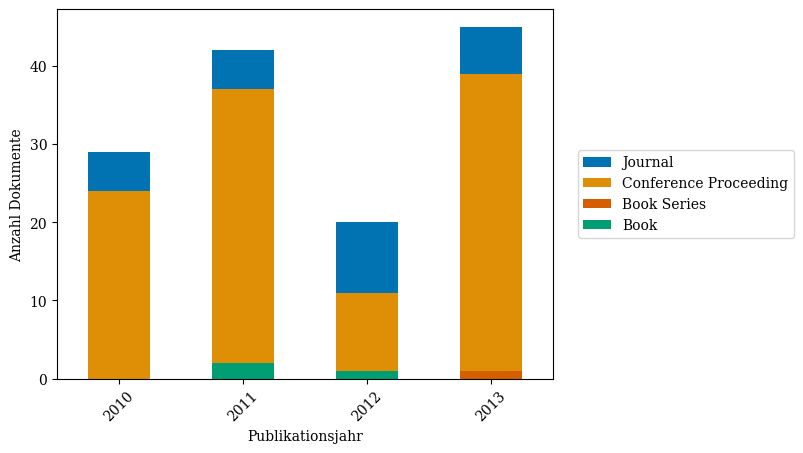

In [218]:
data_2010_only_scopus_final.groupby(
    ["scopus_publication_year", "aggregationType"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_source)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2010_scopus_source_type_year_final.png", bbox_inches="tight", dpi=300
)

In [219]:
data_2010_only_scopus_final["subtypeDescription"].value_counts()

Conference Paper    108
Article              23
Book Chapter          3
Review                2
Name: subtypeDescription, dtype: int64

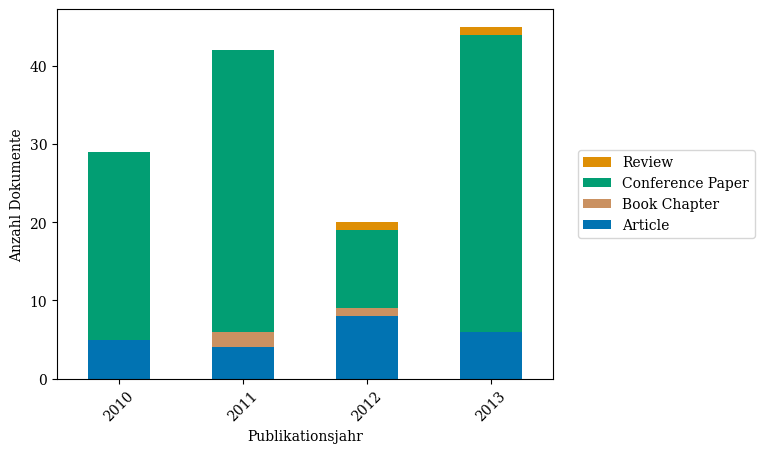

In [220]:
data_2010_only_scopus_final.groupby(
    ["scopus_publication_year", "subtypeDescription"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_type)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2010_scopus_doc_type_year_final.png", bbox_inches="tight", dpi=300
)

In [221]:
# Eingrenzung article: Wieviel der Dokuemnte vom Typ Article konnten final einem Dokument in OpenAlex zugeordnet werden?
# Anzahl alle Dokumente vom Type article
doc_type = "Article"
size_2010_article = (
    data_2010_only_scopus[
        data_2010_only_scopus["subtypeDescription"] == doc_type
    ].shape[0]
    + data_2010_matched[data_2010_matched["subtypeDescription"] == doc_type].shape[0]
)

size_2010_article_notmatched = data_2010_only_scopus[
    data_2010_only_scopus["subtypeDescription"] == doc_type
].shape[0]

# Anzahl dokuemnte vom Typ Article, welche final nicht einen Eintrag in OpenAle xzugeordnetr werden können
size_2010_article_notmatched_final = data_2010_only_scopus_final[
    data_2010_only_scopus_final["subtypeDescription"] == doc_type
].shape[0]

print(
    f"Von {size_2010_article} Suchergebnissen in Scopus vom Dokumententyp {doc_type} konnten {size_2010_article_notmatched} ({size_2010_article_notmatched/size_2010_article*100:.2f} %) durch den direkten Datenbankabgleich \
und {size_2010_article_notmatched_final} ({size_2010_article_notmatched_final/size_2010_article*100:.2f} %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in OpenAlex gefunden werden."
)

Von 2686 Suchergebnissen in Scopus vom Dokumententyp Article konnten 617 (22.97 %) durch den direkten Datenbankabgleich und 23 (0.86 %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in OpenAlex gefunden werden.


In [222]:
# Eingrenzung Conference Paper: Wieviel der Dokumente vom Typ Conference Paper konnten final einem Dokument in OpenAlex zugeordnet werden?
# Anzahl alle Dokumente vom Type Conference Paper
doc_type = "Conference Paper"
size_2010_cp = (
    data_2010_only_scopus[
        data_2010_only_scopus["subtypeDescription"] == doc_type
    ].shape[0]
    + data_2010_matched[data_2010_matched["subtypeDescription"] == doc_type].shape[0]
)

size_2010_cp_notmatched = data_2010_only_scopus[
    data_2010_only_scopus["subtypeDescription"] == doc_type
].shape[0]

# Anzahl dokuemnte vom Typ Conference Paper welche final nicht einen Eintrag in OpenAle xzugeordnetr werden können
size_2010_cp_notmatched_final = data_2010_only_scopus_final[
    data_2010_only_scopus_final["subtypeDescription"] == doc_type
].shape[0]

print(
    f"Von {size_2010_cp} Suchergebnissen in Scopus vom Dokumententyp {doc_type} konnten {size_2010_cp_notmatched} ({size_2010_cp_notmatched/size_2010_cp*100:.2f} %) durch den direkten Datenbankabgleich \
und {size_2010_cp_notmatched_final} ({size_2010_cp_notmatched_final/size_2010_cp*100:.2f} %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in OpenAlex gefunden werden."
)

Von 1190 Suchergebnissen in Scopus vom Dokumententyp Conference Paper konnten 411 (34.54 %) durch den direkten Datenbankabgleich und 108 (9.08 %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in OpenAlex gefunden werden.


In [ ]:
data_2010_only_scopus_final[data_2010_only_scopus_final["aggregationType"] == "Journal"]

#### Final set of unmatched data for 2020  - 2023

In [224]:
data_2020_only_scopus_final.shape[0]

129

In [ ]:
data_2020_only_scopus_final["scopus_source_title"].value_counts()

In [226]:
data_2020_only_scopus_final2[["doi", "scopus_source_title", "issn"]].to_csv(
    "jounral_2020_only_scopus.csv"
)

In [ ]:
data_2020_only_scopus_final2["scopus_source_title"].value_counts()

In [228]:
# sehr kurze Titel?
# atomic layer deposition -> 23

data_2020_only_scopus_final["scopus_title_len"] = data_2020_only_scopus_final[
    "scopus_title"
].str.len()
data_2020_only_scopus_final["scopus_title_len"].value_counts().sort_index()

34     1
37     1
40     2
43     1
45     1
      ..
137    1
140    1
145    1
169    1
230    1
Name: scopus_title_len, Length: 70, dtype: int64

In [ ]:
data_2020_only_scopus_final[
    data_2020_only_scopus_final["scopus_source_title"]
    == "zhenkong kexue yu jishu xuebao/journal of vacuum science and technology"
]

In [230]:
data_2020_only_scopus_final["aggregationType"].value_counts()

Journal                  73
Conference Proceeding    51
Book                      5
Name: aggregationType, dtype: int64

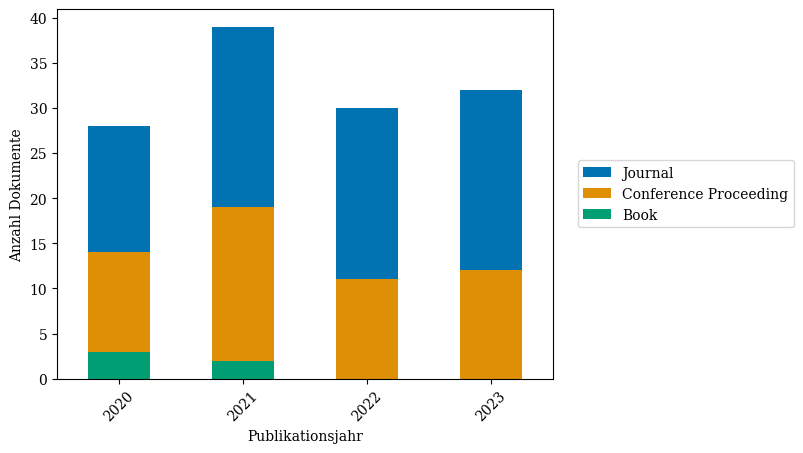

In [231]:
data_2020_only_scopus_final.groupby(
    ["scopus_publication_year", "aggregationType"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_source)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2020_scopus_source_type_year_final.png", bbox_inches="tight", dpi=300
)

In [232]:
data_2020_only_scopus_final["subtypeDescription"].value_counts()

Article             57
Conference Paper    53
Review              14
Book Chapter         5
Name: subtypeDescription, dtype: int64

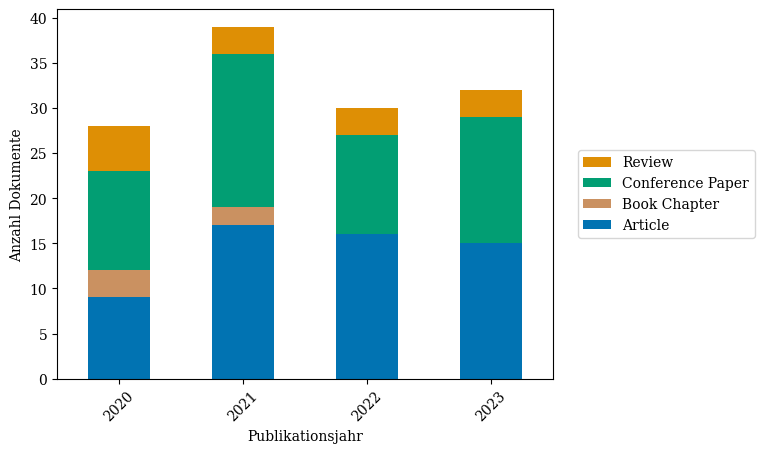

In [233]:
data_2020_only_scopus_final.groupby(
    ["scopus_publication_year", "subtypeDescription"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_type)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2020_scopus_doc_type_year_final.png", bbox_inches="tight", dpi=300
)

In [ ]:
data_2020_only_scopus_final[data_2020_only_scopus_final["aggregationType"] == "Journal"]

In [ ]:
# Wieviel Dokumente wurden nun final in OpenAlex gefunden?
num_all_scopus_data_2020 = data_2020_only_scopus.shape[0] +  data_2020_matched.shape[0]
not_matched_final_2020 = data_2020_only_scopus_final.shape[0]

print(f"Für den Zeitraum 2020 - 2023 wurden initial {num_all_scopus_data_2020} aus Scopus abgefragt. Final konnten {not_matched_final_2020} ({not_matched_final_2020/num_all_scopus_data_2020}%) nicht in openAlex gefunden werden.")


In [235]:
# Eingrenzung article: Wieviel der Dokumente vom Typ Article konnten final einem Dokument in OpenAlex zugeordnet werden?
# Anzahl alle Dokumente vom Type article
doc_type = "Article"
size_2020_article = (
    data_2020_only_scopus[
        data_2020_only_scopus["subtypeDescription"] == doc_type
    ].shape[0]
    + data_2020_matched[data_2020_matched["subtypeDescription"] == doc_type].shape[0]
)
size_2020_article_notmatched = data_2020_only_scopus[
    data_2020_only_scopus["subtypeDescription"] == doc_type
].shape[0]

# Anzahl Dokumente vom Typ Article, welche final nicht einen Eintrag in OpenAlex zugeordnet werden können
size_2020_article_notmatched_final = data_2020_only_scopus_final[
    data_2020_only_scopus_final["subtypeDescription"] == doc_type
].shape[0]

print(
    f"Von {size_2020_article} Suchergebnissen in Scopus vom Dokumententyp {doc_type} konnten {size_2020_article_notmatched} ({size_2020_article_notmatched/size_2020_article*100:.2f} %) durch den direkten Datenbankabgleich \
und {size_2020_article_notmatched_final} ({size_2020_article_notmatched_final/size_2020_article*100:.2f} %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in OpenAlex gefunden werden."
)

Von 5466 Suchergebnissen in Scopus vom Dokumententyp Article konnten 1855 (33.94 %) durch den direkten Datenbankabgleich und 57 (1.04 %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in OpenAlex gefunden werden.


In [236]:
# Eingrenzung Conference Paper: Wieviel der Dokumente vom Typ Conference Paper konnten final einem Dokument in OpenAlex zugeordnet werden?
# Anzahl Dokumente vom Type Conference Paper
doc_type = "Conference Paper"
size_2020_cp = (
    data_2020_only_scopus[
        data_2020_only_scopus["subtypeDescription"] == doc_type
    ].shape[0]
    + data_2020_matched[data_2020_matched["subtypeDescription"] == doc_type].shape[0]
)

size_2020_cp_notmatched = data_2020_only_scopus[
    data_2020_only_scopus["subtypeDescription"] == doc_type
].shape[0]

# Anzahl Dokumente vom Typ Conference Paper, welche final nicht einen Eintrag in OpenAlex zugeordnet werden können
size_2020_cp_notmatched_final = data_2020_only_scopus_final[
    data_2020_only_scopus_final["subtypeDescription"] == doc_type
].shape[0]

print(
    f"Von {size_2020_cp} Suchergebnissen in Scopus vom Dokumententyp {doc_type} konnten {size_2020_cp_notmatched} ({size_2020_cp_notmatched/size_2020_cp*100:.2f} %) durch den direkten Datenbankabgleich \
und {size_2020_cp_notmatched_final} ({size_2020_cp_notmatched_final/size_2020_cp*100:.2f} %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in OpenAlex gefunden werden."
)

Von 586 Suchergebnissen in Scopus vom Dokumententyp Conference Paper konnten 189 (32.25 %) durch den direkten Datenbankabgleich und 53 (9.04 %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in OpenAlex gefunden werden.


## Analyse der Unterschiede - Daten nur in OpenAlex<a class="anchor" id="only_openalex"></a>

In [371]:
data_2010_only_openalex.shape[0]

2077

In [372]:
data_2020_only_openalex.shape[0]

2020

In [369]:
# Daten ohne DOI für 2010 - 2013
data_2010_only_openalex[data_2010_only_openalex["doi"].isnull()].shape[0]

588

In [370]:
# Daten ohne DOI für 2020 - 2023
data_2020_only_openalex[data_2020_only_openalex["doi"].isnull()].shape[0]

159

#### Welche Dokumenttypen liegen vor?

In [237]:
data_2010_only_openalex["type"].value_counts()

article         1979
book-chapter      33
book              22
report            21
review            10
other             10
editorial          1
erratum            1
Name: type, dtype: int64

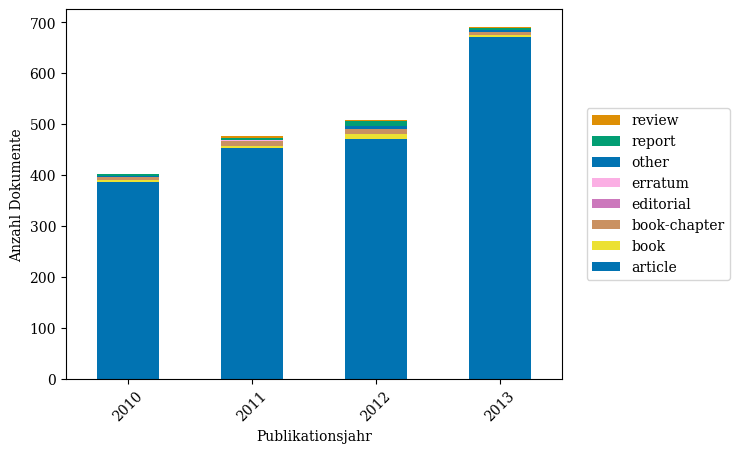

In [238]:
data_2010_only_openalex.groupby(
    ["openalex_publication_year", "type"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_type)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2010_openalex_doc_type_year.png", bbox_inches="tight", dpi=300
)

In [239]:
data_2020_only_openalex["type"].value_counts()

article         1885
book-chapter      56
review            27
report            27
other             13
book               6
editorial          4
erratum            1
letter             1
Name: type, dtype: int64

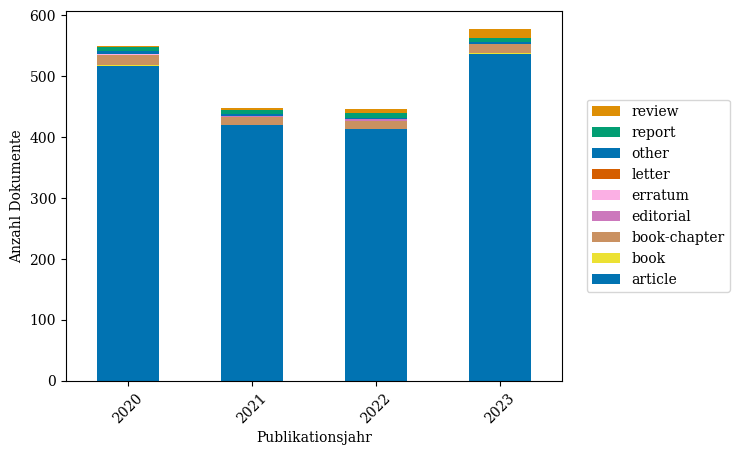

In [240]:
data_2020_only_openalex.groupby(
    ["openalex_publication_year", "type"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_type)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2020_openalex_doc_type_year.png", bbox_inches="tight", dpi=300
)

Aus welchen Quellen stammen die Dokumente?

In [241]:
data_2010_only_openalex["source_type"].value_counts()

journal           1510
conference          50
ebook platform      40
repository          27
book series         20
Name: source_type, dtype: int64

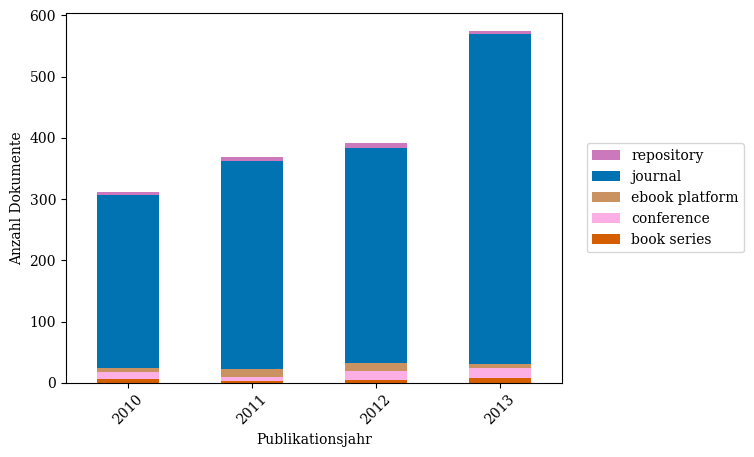

In [242]:
data_2010_only_openalex.groupby(
    ["openalex_publication_year", "source_type"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_source)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2010_openalex_source_type_year.png", bbox_inches="tight", dpi=300
)

In [260]:
data_2020_only_openalex["source_type"].value_counts()

journal           1639
ebook platform      55
conference          29
book series         17
repository          16
Name: source_type, dtype: int64

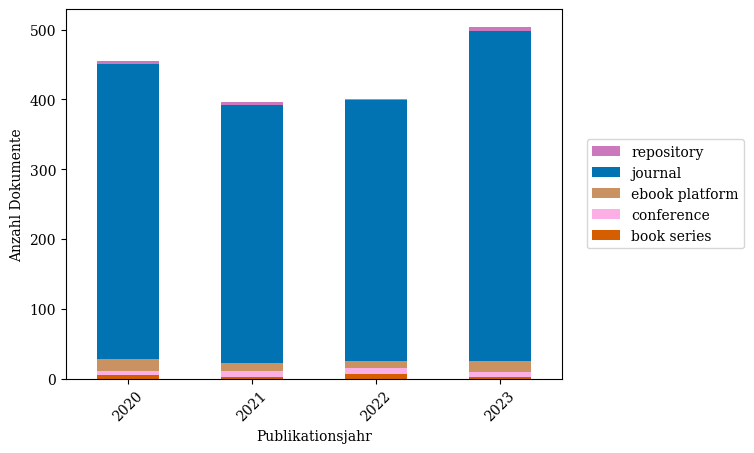

In [244]:
data_2020_only_openalex.groupby(
    ["openalex_publication_year", "source_type"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_source)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2020_openalex_source_type_year.png", bbox_inches="tight", dpi=300
)

In [253]:
# meisten Journale für ungemachte Daten?

data_2010_only_openalex_journal = data_2010_only_openalex[
    data_2010_only_openalex["source_type"] == "journal"
]
print(data_2010_only_openalex_journal.shape[0])

data_2020_only_openalex_journal = data_2020_only_openalex[
    data_2020_only_openalex["source_type"] == "journal"
]
print(data_2020_only_openalex_journal.shape[0])

1510
1639


In [377]:
# Welche Jounrale sind die häufigsten?
# 2010 - 2013
data_2010_only_openalex_journal["openalex_source_title"].value_counts().head(10)

journal of applied physics                                                                    77
the journal of physical chemistry c                                                           46
journal of vacuum science & technology a vacuum surfaces and films                            40
physical review b                                                                             36
langmuir                                                                                      35
proceedings of spie, the international society for optical engineering/proceedings of spie    35
advanced materials                                                                            33
applied physics letters                                                                       31
한국진공학회 학술발표회초록집                                                                               29
advanced materials research                                                                   28
Name: openalex_source_title, d

In [380]:
data_2010_only_openalex_journal[
    data_2010_only_openalex_journal["openalex_source_title"] == "한국진공학회 학술발표회초록집"
]

,Unnamed: 0,openalex_id,doi,openalex_title,type,publication_date,openalex_publication_year,openalex_volume,issue,first_page,...,abstract,openalex_source_title,source_issn,source_type,cited_by_count,referenced_works,openalex_name_1st_author,uuid,matched,score
1503,1524,https://openalex.org/W2216691256,NaN,precursor chemistry for atomic layer deposition,article,2013-08-01,2013,NaN,NaN,76,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,1,[],Chung,NaN,False,NaN
1538,1561,https://openalex.org/W1523283319,NaN,hybrid organic-inorganic films fabricated usin...,article,2013-08-01,2013,NaN,NaN,75,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,1,[],George,NaN,False,NaN
1539,1563,https://openalex.org/W1580932077,NaN,atomic layer deposition for display applications,article,2013-08-01,2013,NaN,NaN,76,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,0,[],Park,NaN,False,NaN
1559,1583,https://openalex.org/W2200357644,NaN,atomic layer deposition for energy devices and...,article,2013-08-01,2013,NaN,NaN,77,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,0,[],Kim,NaN,False,NaN
1582,1609,https://openalex.org/W2259920848,NaN,[invited talk] heterogeneous catalysts fabrica...,article,2013-02-01,2013,NaN,NaN,128,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,0,[],Kim,NaN,False,NaN
1587,1614,https://openalex.org/W1912663086,NaN,three-dimensional nanofabrication with nanotra...,article,2010-02-01,2010,NaN,NaN,87,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,0,[],김수환,NaN,False,NaN
1591,1620,https://openalex.org/W2132207283,NaN,tio2 nanotubes fabricated by atomic layer depo...,article,2011-08-01,2011,NaN,NaN,161,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,0,[],Jung,NaN,False,NaN
1596,1625,https://openalex.org/W2212797407,NaN,uv-enhanced atomic layer deposition of al2o3 t...,article,2011-08-01,2011,NaN,NaN,256,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,0,[],윤관혁,NaN,False,NaN
1601,1631,https://openalex.org/W2267897630,NaN,application of atomic layer deposition to elec...,article,2013-08-01,2013,NaN,NaN,319,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,0,[],Kim,NaN,False,NaN
1608,1638,https://openalex.org/W1508619031,NaN,atomic layer deposition of sb₂s₃ thin films on...,article,2013-02-01,2013,NaN,NaN,282,...,NaN,한국진공학회 학술발표회초록집,NaN,journal,0,[],한규석,NaN,False,NaN


In [378]:
# Welche Journale sind die häufigsten?
# 2020 - 2023
data_2020_only_openalex_journal["openalex_source_title"].value_counts().head(10)

acs applied materials & interfaces                                    59
nanomaterials                                                         45
ccs chemistry                                                         43
acs nano                                                              40
coatings                                                              35
the journal of physical chemistry c                                   32
small                                                                 30
journal of vacuum science & technology a vacuum surfaces and films    27
materials                                                             26
advanced materials interfaces                                         25
Name: openalex_source_title, dtype: int64

In [12]:
# Welche keywords?
data_2010_only_openalex["keywords"].value_counts().head(20)

Deposition                             227
Passivation                             16
Deposition, Layer by layer              15
Pulsed Laser Deposition                 15
Passivation, Deposition                 11
Deposition, Atomic layer epitaxy         9
Characterization                         9
Carbon fibers                            9
Morphology                               8
Layer by layer                           8
Buffer (optical fiber)                   7
Crystal (programming language)           7
Electron Mobility                        6
Magnetism                                5
Deposition, Barrier layer                5
Nanoporous, Deposition                   5
Pulsed Laser Deposition, Deposition      5
High-κ dielectric                        5
Quantum Efficiency                       4
Cavity magnetron                         4
Name: keywords, dtype: int64

In [24]:
# Anzahl genutzter keywords
data_2010_only_openalex["keywords"].value_counts().shape[0]

1268

In [23]:
# Dokumente ohne Keywords
data_2010_only_openalex[data_2010_only_openalex["keywords"].isnull()].shape[0]

288

In [13]:
# Welche keywords?
data_2020_only_openalex["keywords"].value_counts().head(20)

Deposition                             162
Deposition, Layer by layer              20
Passivation                             12
Crystal (programming language)          10
Pulsed Laser Deposition                 10
Molybdenum disulfide                     9
Surface Modification                     9
Pulsed Laser Deposition, Deposition      9
Ellipsometry                             8
Morphology                               7
Nanomaterials                            7
Ohmic contact                            6
Exfoliation joint                        6
Electron Mobility                        6
Passivation, Deposition                  6
Deposition, Atomic layer epitaxy         6
Carbon fibers                            6
Cavity magnetron                         5
Topological insulator                    4
Nanorod                                  4
Name: keywords, dtype: int64

In [15]:
# Anzahl genutzer Keywords
data_2020_only_openalex["keywords"].value_counts().shape[0]

1244

In [21]:
# Dokumente ohne Keywords
data_2020_only_openalex[data_2020_only_openalex["keywords"].isnull()].shape[0]

345

Bei Publikationen  die nur in OpenAlex vorhanden sind gibt es zverschiedene mögliche Ursache:   
a) die Verknüpfung zu einem Dokument in Scopus wurde wärend des Matchings nicht erstellt (z.B. da keine DOI und unvollständige Metdataen),
b) die Daten sind in Scopus vorhanden waren aber nicht Teil der initialen Datenbankabfrage oder    
c) die Daten würden im Rahmen der Datenbereinigung entfernt.  

Um dies zu testen, werden anhand der DOI geprüft ob der Datensatz nicht doch in Scopus vorhanden ist.

In [307]:
dois_nur_openalex_2010 = data_2010_only_openalex["doi"].dropna()
dois_nur_openalex_2020 = data_2020_only_openalex["doi"].dropna()

In [308]:
dois_nur_openalex_2010

0                   10.1021/cm402221y
1              10.1002/adma.201104798
2           10.1007/978-1-4614-8054-9
3                   10.1021/nl4035626
4                  10.1039/c3ee42704h
                    ...              
1484    10.1109/escinano.2012.6149627
1485                 10.1002/pip.2447
1486                  10.2172/1051937
1487                 10.1002/xrs.2424
1488                10.1063/pt.3.1924
Name: doi, Length: 1489, dtype: object

In [324]:
print(dois_nur_openalex_2010.shape[0])
print(dois_nur_openalex_2020.shape[0])

1489
1861


In [326]:
def get_scopus_works_from_doi(doi_list):
    all_works_scopus = []
    dois_not_found = []

    for doi in doi_list:
        # save data if entry found
        work = ScopusSearch(f"DOI({doi})", download=True)
        if work.results is not None:  # could be None
            all_works_scopus.append(work.results)
        else:
            # HTTP error if doi not in OpenAlex
            dois_not_found.append(doi)

    # dataframe from dictiony
    # Create a DataFrame from the list, flattening each sublist into rows
    all_works_scopus_df = pd.DataFrame(
        [item for sublist in all_works_scopus for item in sublist]
    )

    return (all_works_scopus_df, dois_not_found)

In [327]:
# check for DOI in Scopus

data_2010_scopus_from_openalex, scopus_not_found_2010 = get_scopus_works_from_doi(
    dois_nur_openalex_2010
)

In [328]:
data_2020_scopus_from_openalex, scopus_not_found_2020 = get_scopus_works_from_doi(
    dois_nur_openalex_2020
)

In [ ]:
data_2010_scopus_from_openalex.head(5)

In [ ]:
data_2020_scopus_from_openalex.head(5)

In [316]:
data_2010_scopus_from_openalex.columns

Index(['eid', 'doi', 'pii', 'pubmed_id', 'title', 'subtype',
       'subtypeDescription', 'creator', 'afid', 'affilname',
       'affiliation_city', 'affiliation_country', 'author_count',
       'author_names', 'author_ids', 'author_afids', 'coverDate',
       'coverDisplayDate', 'publicationName', 'issn', 'source_id', 'eIssn',
       'aggregationType', 'volume', 'issueIdentifier', 'article_number',
       'pageRange', 'description', 'authkeywords', 'citedby_count',
       'openaccess', 'freetoread', 'freetoreadLabel', 'fund_acr', 'fund_no',
       'fund_sponsor'],
      dtype='object')

In [331]:
# Publikationsjahr in seperater Spalte
data_2010_scopus_from_openalex["publication_year"] = (
    data_2010_scopus_from_openalex["coverDate"].str.split("-").str[0]
)
data_2020_scopus_from_openalex["publication_year"] = (
    data_2020_scopus_from_openalex["coverDate"].str.split("-").str[0]
)

In [336]:
print(
    f"Von {data_2010_only_openalex.shape[0]} nicht gematchten Publikationen haben {dois_nur_openalex_2010.shape[0]} eine DOI. Hier von konnte für {data_2010_scopus_from_openalex.shape[0]} ein Eintrag in Scopus gefunden werden. \
    \n{len(scopus_not_found_2010)} DOIs konnten nicht in Scopus gefunden werden."
)

# Welchen Jahren sind diese Daten zugeordnet?
data_2010_scopus_from_openalex["publication_year"].value_counts().sort_index()

Von 2077 nicht gematchten Publikationen haben 1489 eine DOI. Hier von konnte für 1191 ein Eintrag in Scopus gefunden werden.     
301 DOIs konnten nicht in OpenAlex gefunden werden.


2010    215
2011    256
2012    271
2013    288
2014    160
2015      1
Name: publication_year, dtype: int64

In [338]:
print(
    f"Von {data_2020_only_openalex.shape[0]} nicht gematchten Publikationen haben {dois_nur_openalex_2020.shape[0]} eine DOI. Hier von konnte für {data_2020_scopus_from_openalex.shape[0]} ein Eintrag in Scopus gefunden werden. \
    \n{len(scopus_not_found_2020)} DOIs konnten nicht in Scopus gefunden werden."
)

# Welchen Jahren sind diese Daten zugeordnet?
data_2020_scopus_from_openalex["publication_year"].value_counts().sort_index()

Von 2020 nicht gematchten Publikationen haben 1861 eine DOI. Hier von konnte für 1366 ein Eintrag in Scopus gefunden werden.     
496 DOIs konnten nicht in Scopus gefunden werden.


2019      3
2020    280
2021    291
2022    339
2023    294
2024    158
2025      1
Name: publication_year, dtype: int64

In [368]:
# 2010 - 2013: Gibt es Daten welche nun in Scopus via DOI gefunden wurden, welche in der initialen Datenabfrage in Scopus gefunden wurden, aber evtl. in der Datenbereinigung entfernt wurden?
data_scopus_2010 = pd.read_csv("../data/raw/data_scopus_2010.csv")

initialy_found_scopus_2010 = 0
for id in data_2010_scopus_from_openalex["eid"]:
    if id in data_scopus_2010["eid"]:
        initialy_found_scopus_2010 += 1

initialy_found_scopus_2010

0

In [367]:
# 2020 - 2023: Gibt es Daten welche nun in Scopus via DOI gefunden wurden, welche in der initialen Datenabfrage in Scopus gefunden wurden, aber evtl. in der Datenbereinigung entfernt wurden?
data_scopus_2020 = pd.read_csv("../data/raw/data_scopus_2020.csv")

initialy_found_scopus_2020 = 0
for id in data_2020_scopus_from_openalex["eid"]:
    if id in data_scopus_2020["eid"]:
        initialy_found_scopus_2020 += 1

initialy_found_scopus_2020

0

In [340]:
# collect final not matched documents, even after searching for the dois in OpenAlex

# 2010 - 2013
data_2010_only_openalex_final1 = data_2010_only_openalex[  # Daten ohne DOI
    data_2010_only_openalex["doi"].isnull()
]

data_2010_only_openalex_final2 = data_2010_only_openalex.query(
    "doi in @scopus_not_found_2010"
)  # Daten mit DOI aber nicht in Scopus gefunden
data_2010_only_openalex_final = pd.concat(
    [data_2010_only_openalex_final1, data_2010_only_openalex_final2]
)

data_2010_only_openalex_final.to_csv("../data/diff/data_2010_only_openalex_final.csv")

# 2020 - 2023
data_2020_only_openalex_final1 = data_2020_only_openalex[  # Daten ohne DOI
    data_2020_only_openalex["doi"].isnull()
]
data_2020_only_openalex_final2 = data_2020_only_openalex.query(
    "doi in @scopus_not_found_2020"
)  # Daten mit DOI aber nicht in Scopus gefunden
data_2020_only_openalex_final = pd.concat(
    [data_2020_only_openalex_final1, data_2020_only_openalex_final2]
)
data_2020_only_openalex_final.to_csv("../data/diff/data_2020_only_openalex_final.csv")

#### Final set of unmatched data for 2010  - 2013

In [364]:
data_2010_only_openalex_final.shape[0]

889

In [347]:
data_2010_only_openalex_final["type"].value_counts()

article         804
book-chapter     31
book             21
report           21
other            10
review            2
Name: type, dtype: int64

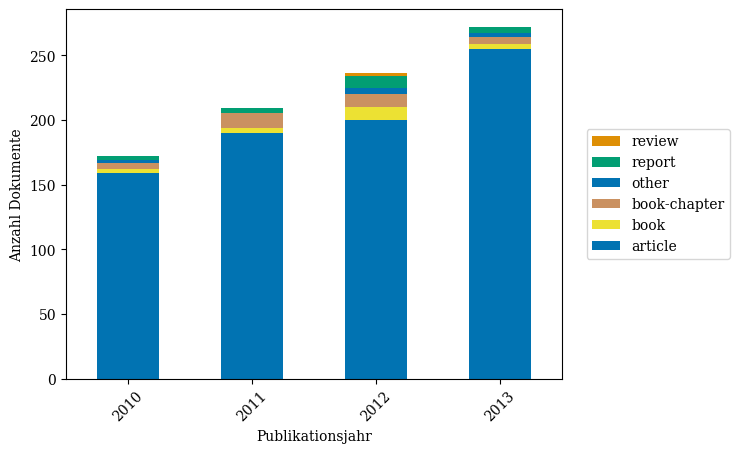

In [345]:
data_2010_only_openalex_final.groupby(
    ["openalex_publication_year", "type"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_type)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2010_openalex_doc_type_year_final.png", bbox_inches="tight", dpi=300
)

In [351]:
# Eingrenzung article: Wieviel der Dokuemnte vom Typ article konnten final einem Dokument in OpenAlex zugeordnet werden?
# Anzahl alle Dokumente vom Type article
doc_type = "article"
size_2010_article = (
    data_2010_only_openalex[data_2010_only_openalex["type"] == doc_type].shape[0]
    + data_2010_matched[data_2010_matched["type"] == doc_type].shape[0]
)

size_2010_article_notmatched = data_2010_only_openalex[
    data_2010_only_openalex["type"] == doc_type
].shape[0]

# Anzahl Dokumente vom Typ article, welche final nicht einen Eintrag in OpenAlex zugeordnet werden können
size_2010_article_notmatched_final = data_2010_only_openalex_final[
    data_2010_only_openalex_final["type"] == doc_type
].shape[0]

print(
    f"Von {size_2010_article} Suchergebnissen in OpenAlex vom Dokumententyp {doc_type} konnten {size_2010_article_notmatched} ({size_2010_article_notmatched/size_2010_article*100:.2f} %) durch den direkten Datenbankabgleich \
und {size_2010_article_notmatched_final} ({size_2010_article_notmatched_final/size_2010_article*100:.2f} %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in Scopus gefunden werden."
)

Von 4858 Suchergebnissen in OpenAlex vom Dokumententyp article konnten 1979 (40.74 %) durch den direkten Datenbankabgleich und 804 (16.55 %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in Scopus gefunden werden.


In [359]:
# sehr kurze Titel?
# atomic layer deposition -> 23

data_2010_only_openalex_final["openalex_title_len"] = data_2010_only_openalex_final[
    "openalex_title"
].str.len()
data_2010_only_openalex_final["openalex_title_len"].value_counts().sort_index()

4      1
17     1
18     2
21     1
22     2
      ..
205    1
215    2
219    1
235    2
471    1
Name: openalex_title_len, Length: 151, dtype: int64

In [362]:
data_2010_only_openalex_final[data_2010_only_openalex_final["openalex_title_len"] < 23]

,Unnamed: 0,openalex_id,doi,openalex_title,type,publication_date,openalex_publication_year,openalex_volume,issue,first_page,...,openalex_source_title,source_issn,source_type,cited_by_count,referenced_works,openalex_name_1st_author,uuid,matched,score,openalex_title_len
1799,1838,https://openalex.org/W569277178,NaN,atom probe microscopy,book,2012-08-26,2012,NaN,NaN,NaN,...,NaN,NaN,NaN,540,[],Gault,NaN,False,NaN,21
1862,1907,https://openalex.org/W1510098893,NaN,스퍼터 증착을 이용한 선택적 투과막 형성,article,2011-02-01,2011,2011,2,144,...,NaN,NaN,NaN,0,[],정소운,NaN,False,NaN,22
523,531,https://openalex.org/W4211104379,10.1002/9780470876510.ch7,vacuum deposition,other,2010-06-14,2010,NaN,NaN,199,...,NaN,NaN,NaN,1,"['https://openalex.org/W1626800832', 'https://...",Bishop,NaN,False,NaN,17
1402,1416,https://openalex.org/W4250764681,10.1117/3.176482.ch9,multilayer fabrication,book-chapter,2010-03-16,2010,NaN,NaN,169,...,spie ebooks,NaN,ebook platform,0,[],Spiller,NaN,False,NaN,22
1419,1433,https://openalex.org/W4236156963,10.1063/pt.3.1794,focus on materials,article,2012-10-31,2012,65,11,62,...,physics today,"['0031-9228', '1945-0699']",journal,0,[],Mandelis,NaN,False,NaN,18
1477,1491,https://openalex.org/W2062880910,10.1063/pt.3.2185,focus on materials,article,2013-11-01,2013,66,11,60,...,physics today,"['0031-9228', '1945-0699']",journal,0,[],Mandelis,NaN,False,NaN,18
1487,1501,https://openalex.org/W4243867646,10.1002/xrs.2424,news,article,2012-10-15,2012,41,6,425,...,x-ray spectrometry,"['0049-8246', '1097-4539']",journal,0,[],Sakurai,NaN,False,NaN,4


In [350]:
data_2010_only_openalex_final["source_type"].value_counts()

journal           400
ebook platform     39
conference         34
repository         27
book series         5
Name: source_type, dtype: int64

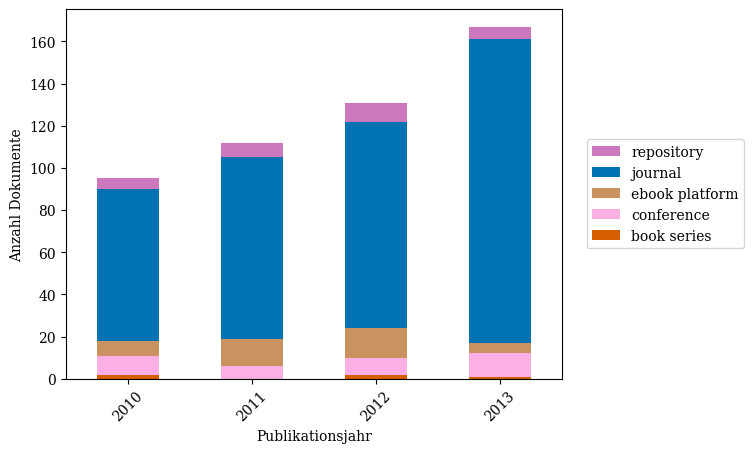

In [341]:
data_2010_only_openalex_final.groupby(
    ["openalex_publication_year", "source_type"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_source)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2010_openalex_source_type_year_final.png",
    bbox_inches="tight",
    dpi=300,
)

In [374]:
# Welche Quellen?
data_2010_only_openalex_final["openalex_source_title"].value_counts().head(10)

한국진공학회 학술발표회초록집                                       29
bulletin of the american physical society             23
phdt                                                  18
cheminform                                            16
intech ebooks                                         14
world conference on photovoltaic energy conversion    13
the japan society of applied physics                  10
applied science and convergence technology            10
한국고분자학회 학술대회 연구논문 초록집                                  9
acta physica sinica                                    8
Name: openalex_source_title, dtype: int64

In [373]:
data_2010_only_openalex_final[
    data_2010_only_openalex_final["openalex_source_title"] == "phdt"
]

,Unnamed: 0,openalex_id,doi,openalex_title,type,publication_date,openalex_publication_year,openalex_volume,issue,first_page,...,openalex_source_title,source_issn,source_type,cited_by_count,referenced_works,openalex_name_1st_author,uuid,matched,score,openalex_title_len
1497,1517,https://openalex.org/W71222699,NaN,atomic layer deposition on fiber forming polym...,article,2010-03-22,2010,NaN,NaN,NaN,...,phdt,NaN,repository,3,[],Spagnola,NaN,False,NaN,80
1524,1547,https://openalex.org/W1648660367,NaN,controlling interface chemistry of high mobili...,article,2010-01-01,2010,NaN,NaN,NaN,...,phdt,NaN,repository,1,[],Milojević,NaN,False,NaN,114
1533,1556,https://openalex.org/W2524868090,NaN,"growth, characterization and post-processing o...",article,2012-01-01,2012,NaN,NaN,NaN,...,phdt,NaN,repository,3,"['https://openalex.org/W1481178155', 'https://...",Абдулагатов,NaN,False,NaN,162
1565,1589,https://openalex.org/W3036790513,NaN,investigation of atomic layer deposition for t...,article,2010-01-01,2010,NaN,NaN,NaN,...,phdt,NaN,repository,0,[],Comstock,NaN,False,NaN,88
1585,1612,https://openalex.org/W2268470692,NaN,atomic layer deposition of materials in the cu...,article,2013-01-01,2013,NaN,NaN,NaN,...,phdt,NaN,repository,0,[],Short,NaN,False,NaN,93
1618,1648,https://openalex.org/W2294108604,NaN,atomic layer deposition for improved electroch...,article,2011-12-01,2011,NaN,NaN,NaN,...,phdt,NaN,repository,0,[],Riley,NaN,False,NaN,88
1621,1651,https://openalex.org/W2576641679,NaN,advanced lithium ion battery materials prepare...,article,2011-01-01,2011,NaN,NaN,NaN,...,phdt,NaN,repository,0,[],Cavanagh,NaN,False,NaN,76
1670,1700,https://openalex.org/W2521905024,NaN,fundamental studies of water oxidation at mode...,article,2013-01-01,2013,NaN,NaN,NaN,...,phdt,NaN,repository,0,[],Klahr,NaN,False,NaN,103
1671,1701,https://openalex.org/W2522031834,NaN,development of group iii/nitride core/shell he...,article,2013-01-01,2013,NaN,NaN,NaN,...,phdt,NaN,repository,0,"['https://openalex.org/W1498734336', 'https://...",Revelli,NaN,False,NaN,99
1676,1706,https://openalex.org/W1658456209,NaN,plasma-enhanced atomic layer deposition zinc o...,article,2010-06-30,2010,NaN,NaN,NaN,...,phdt,NaN,repository,0,[],Mourey,NaN,False,NaN,92


In [355]:
# Nur Journale
data_2010_only_openalex_final_journal = data_2010_only_openalex_final[
    data_2010_only_openalex_final["source_type"] == "journal"
]
data_2010_only_openalex_final_journal["openalex_source_title"].value_counts()

한국진공학회 학술발표회초록집                                               29
bulletin of the american physical society                     23
cheminform                                                    16
applied science and convergence technology                    10
the japan society of applied physics                          10
                                                              ..
전기전자재료학회논문지(j. korean inst. electr. electron. mater. eng.)     1
cailiao kexue yu gongcheng xuebao                              1
bulletin of pure & applied sciences- physics                   1
稀有金属材料与工程                                                      1
x-ray spectrometry                                             1
Name: openalex_source_title, Length: 185, dtype: int64

#### Final set of unmatched data for 2020  - 2023

In [365]:
data_2020_only_openalex_final.shape[0]

655

In [348]:
data_2020_only_openalex_final["type"].value_counts()

article         558
book-chapter     47
report           27
other            10
review            6
book              6
erratum           1
Name: type, dtype: int64

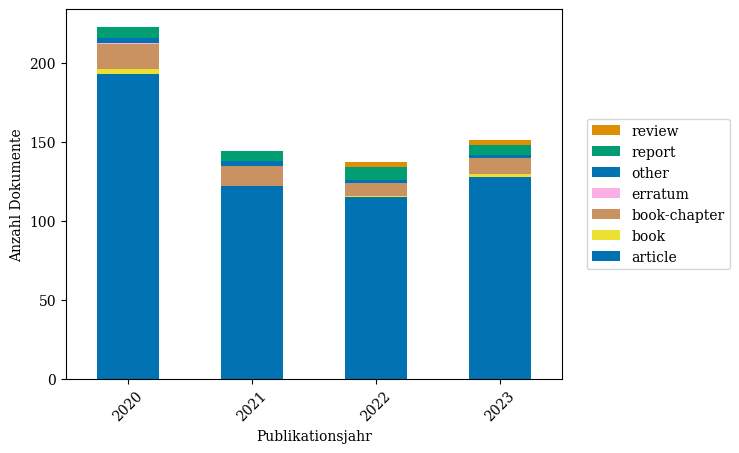

In [346]:
data_2020_only_openalex_final.groupby(
    ["openalex_publication_year", "type"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_type)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2020_openalex_doc_type_year_final.png", bbox_inches="tight", dpi=300
)

In [352]:
# Eingrenzung article: Wieviel der Dokumente vom Typ article konnten final einem Dokument in OpenAlex zugeordnet werden?
# Anzahl alle Dokumente vom Type article
doc_type = "article"
size_2020_article = (
    data_2020_only_openalex[data_2020_only_openalex["type"] == doc_type].shape[0]
    + data_2020_matched[data_2020_matched["type"] == doc_type].shape[0]
)

size_2020_article_notmatched = data_2020_only_openalex[
    data_2020_only_openalex["type"] == doc_type
].shape[0]

# Anzahl Dokumente vom Typ article, welche final nicht einen Eintrag in OpenAlex zugeordnet werden können
size_2020_article_notmatched_final = data_2020_only_openalex_final[
    data_2020_only_openalex_final["type"] == doc_type
].shape[0]

print(
    f"Von {size_2020_article} Suchergebnissen in OpenAlex vom Dokumententyp {doc_type} konnten {size_2020_article_notmatched} ({size_2020_article_notmatched/size_2020_article*100:.2f} %) durch den direkten Datenbankabgleich \
und {size_2020_article_notmatched_final} ({size_2020_article_notmatched_final/size_2020_article*100:.2f} %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in Scopus gefunden werden."
)

Von 6025 Suchergebnissen in OpenAlex vom Dokumententyp article konnten 1885 (31.29 %) durch den direkten Datenbankabgleich und 558 (9.26 %) final (nach zusätzlicher gezielter Abfrage per DOI) nicht in Scopus gefunden werden.


In [361]:
# sehr kurze Titel?
# atomic layer deposition -> 23

data_2020_only_openalex_final["openalex_title_len"] = data_2020_only_openalex_final[
    "openalex_title"
].str.len()
data_2020_only_openalex_final["openalex_title_len"].value_counts().sort_index()

4      1
13     1
14     1
17     1
18     2
      ..
212    1
217    1
226    2
261    1
275    1
Name: openalex_title_len, Length: 158, dtype: int64

In [363]:
data_2020_only_openalex_final[data_2020_only_openalex_final["openalex_title_len"] < 23]

,Unnamed: 0,openalex_id,doi,openalex_title,type,publication_date,openalex_publication_year,openalex_volume,issue,first_page,...,openalex_source_title,source_issn,source_type,cited_by_count,referenced_works,openalex_name_1st_author,uuid,matched,score,openalex_title_len
329,338,https://openalex.org/W4308102055,10.1002/9781118971499.ch10,ferrite films,other,2022-10-28,2022,NaN,NaN,295,...,NaN,NaN,NaN,3,"['https://openalex.org/W138060149', 'https://o...",Zaag,NaN,False,NaN,13
469,479,https://openalex.org/W4324008740,10.1007/978-3-031-18784-1_4,semiconductors,book-chapter,2023-01-01,2023,NaN,NaN,291,...,materials chemistry,"['0390-6035', '1878-6057']",journal,1,"['https://openalex.org/W130601995', 'https://o...",Fahlman,NaN,False,NaN,14
1451,1462,https://openalex.org/W4200289986,10.1049/pbcs063e_appendixb,fabrication techniques,book-chapter,2021-10-01,2021,NaN,NaN,165,...,institution of engineering and technology ebooks,NaN,ebook platform,0,[],NaN,NaN,False,NaN,22
1478,1495,https://openalex.org/W4296142778,10.21883/sc.2022.02.53045.9748,9748,article,2022-01-01,2022,56,2,210,...,физика и техника полупроводников,"['0015-3222', '1726-7315']",journal,0,[],Uvarov,NaN,False,NaN,4
1493,1510,https://openalex.org/W4214663423,10.1515/9783110760613-204,abbreviations list,book-chapter,2022-02-21,2022,NaN,NaN,XI,...,de gruyter ebooks,NaN,ebook platform,0,[],Dimethylsulfoxide,NaN,False,NaN,18
1628,1648,https://openalex.org/W3212920921,10.1515/9783110614893-203,preface from authors,book-chapter,2021-11-08,2021,NaN,NaN,VII,...,de gruyter ebooks,NaN,ebook platform,0,[],Qiu,NaN,False,NaN,20
1653,1673,https://openalex.org/W3022371449,10.1201/9780429022944-43,vapor phase epitaxy,book-chapter,2020-05-06,2020,NaN,NaN,487,...,apple academic press ebooks,NaN,ebook platform,0,['https://openalex.org/W2045721903'],Attolini,NaN,False,NaN,19
1721,1741,https://openalex.org/W4388675278,10.1109/nap59739.2023.10310681,table of contents,article,2023-09-10,2023,NaN,NaN,C,...,2022 ieee 12th international conference nanoma...,NaN,conference,0,[],Novosad,NaN,False,NaN,17
1734,1754,https://openalex.org/W4256481232,10.1201/9780429347313-5,epitaxial silicene,book-chapter,2020-04-02,2020,NaN,NaN,5,...,crc press ebooks,NaN,ebook platform,0,[],Solonenko,NaN,False,NaN,18
1764,1784,https://openalex.org/W3154932565,10.1093/oso/9780198834618.003.0005,two-dimensional oxides,book-chapter,2021-02-25,2021,NaN,NaN,127,...,oxford university press ebooks,NaN,ebook platform,0,[],Netzer,NaN,False,NaN,22


In [349]:
data_2020_only_openalex_final["source_type"].value_counts()

journal           350
ebook platform     48
conference         22
repository         16
book series         3
Name: source_type, dtype: int64

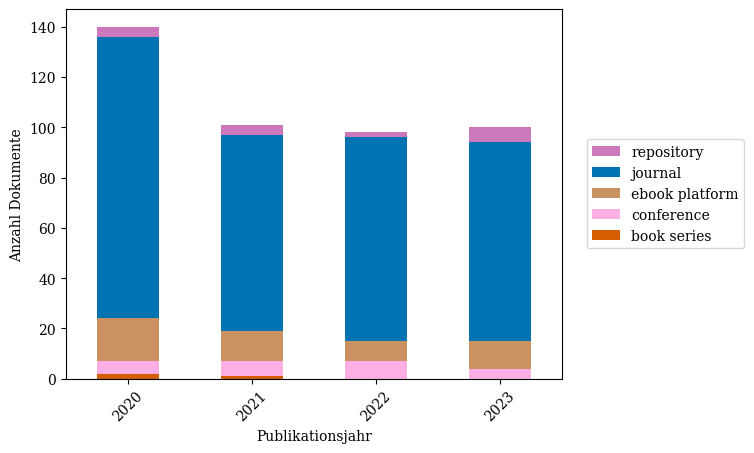

In [343]:
data_2020_only_openalex_final.groupby(
    ["openalex_publication_year", "source_type"]
).size().unstack().plot(kind="bar", stacked=True, color=colorDict_source)

# rotate x-axis labels
plt.xticks(rotation=45)

# add axis titles
plt.xlabel("Publikationsjahr")
plt.ylabel("Anzahl Dokumente")

# set label outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0,
)
plt.savefig(
    "figures/plot_2020_openalex_source_type_year_final.png",
    bbox_inches="tight",
    dpi=300,
)

In [356]:
# Welche Quellen?
data_2020_only_openalex_final["openalex_source_title"].value_counts()

the japan society of applied physics              22
crc press ebooks                                  18
физика твердого тела                              15
angewandte chemie                                 13
физика и техника полупроводников                  12
                                                  ..
ieee microwave and wireless technology letters     1
advances in materials physics and chemistry        1
asm international ebooks                           1
journal of magnetism and magnetic materials        1
international journal of particle therapy          1
Name: openalex_source_title, Length: 222, dtype: int64

In [357]:
# Nur Journale
data_2010_only_openalex_final_journal = data_2010_only_openalex_final[
    data_2010_only_openalex_final["source_type"] == "journal"
]
data_2010_only_openalex_final_journal["openalex_source_title"].value_counts()

한국진공학회 학술발표회초록집                                               29
bulletin of the american physical society                     23
cheminform                                                    16
applied science and convergence technology                    10
the japan society of applied physics                          10
                                                              ..
전기전자재료학회논문지(j. korean inst. electr. electron. mater. eng.)     1
cailiao kexue yu gongcheng xuebao                              1
bulletin of pure & applied sciences- physics                   1
稀有金属材料与工程                                                      1
x-ray spectrometry                                             1
Name: openalex_source_title, Length: 185, dtype: int64